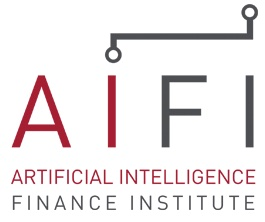


# Bootcamp - Python and Coding - Deep Learning

# Recurrent Neural Networks (RNN)

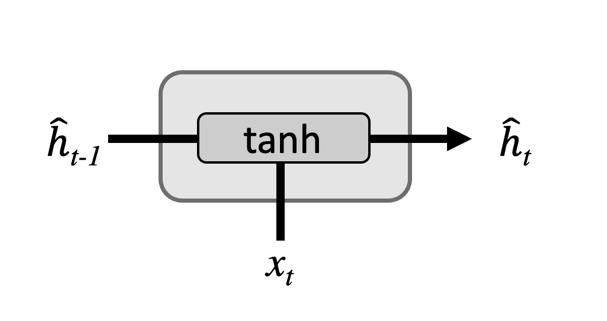

<font size=5>
$$
\begin{aligned}
h_{t} &=\tanh \left(X_{t} \cdot W_{x h}+h_{t-1} \cdot W_{h h}+b_{h}\right) \\
&=\phi_{h}\left(\left[X_{t} h_{t-1}\right] \cdot W+b_{h}\right) \\
o_{t} &=h_{t} \cdot W_{y h}+b_{y} \\
\hat{y}_{t} &=\operatorname{softmax}\left(o_{t}\right)
\end{aligned}
$$
    </font
    
[Math snipping tool](https://mathpix.com/)  

|Input gate  | Forget gate   | Gate  | Output gate   | 
|---|---|---|---|
Write to cell or not? | Erase a cell or not?  | How much to write to cell? | How much to reveal cell?


			
			


## RNN vs. LSTM - A Small Comparison
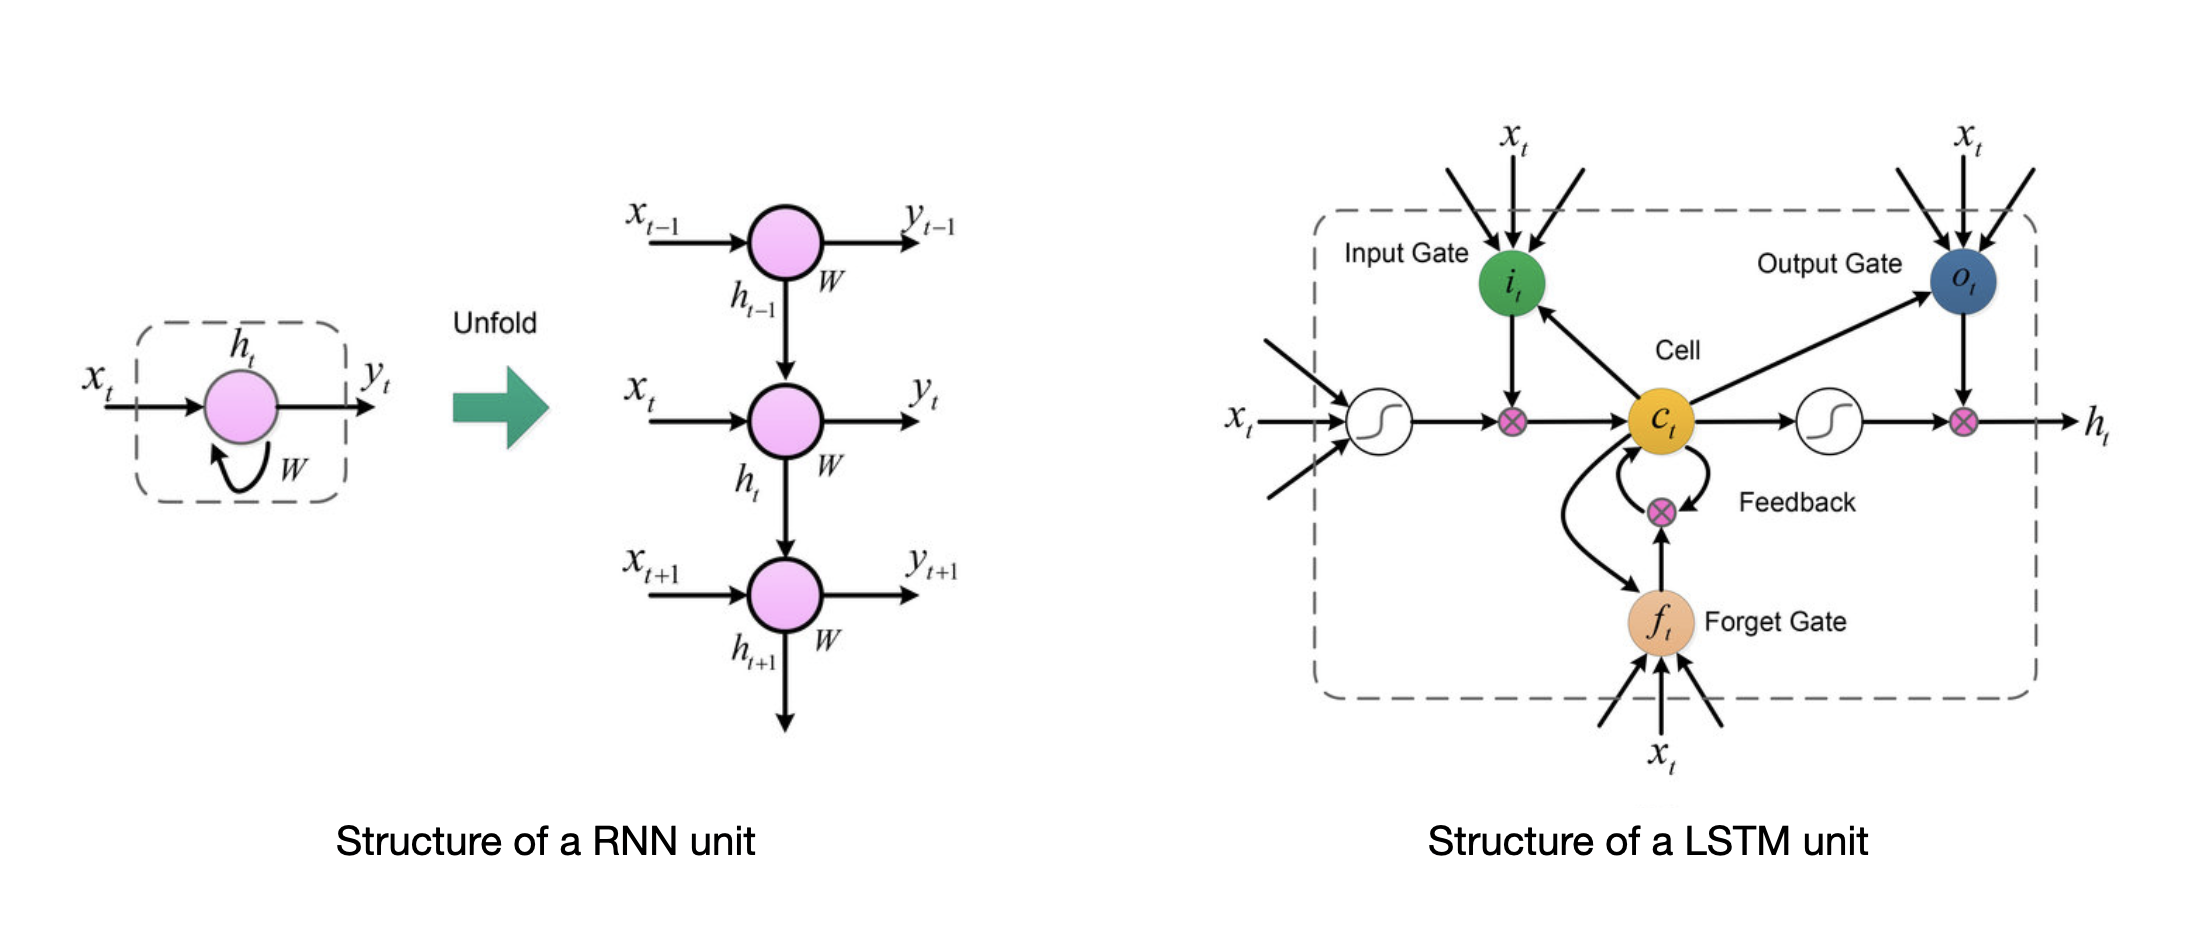

## Backpropagation

Most deep learning frameworks provide an automatic differentiation procedure to compute gradients
based on the backpropagation algorithm. In these frameworks, all computations
are represented as a graph and therefore also the gradient computation becomes a graph.
Below you find a simple network. 

A computational graph is a directed graph that represents a mathematical function or a sequence of functions. In backpropagation, the computational graph is used to efficiently calculate the gradients of the loss function with respect to the weights of a neural network, by applying the chain rule of derivatives to the nodes in the graph.

From the chain rule we have that

$$
\frac{\partial l}{\partial h_{1}}=\frac{\partial l}{\partial h_{3}} \frac{\partial h_{3}}{\partial h_{2}} \frac{\partial h_{2}}{\partial h_{1}}\left(=\frac{\partial l}{\partial h_{2}} \frac{\partial h_{2}}{\partial h_{1}}\right)
$$

which can be represented as a computational graph as follows:

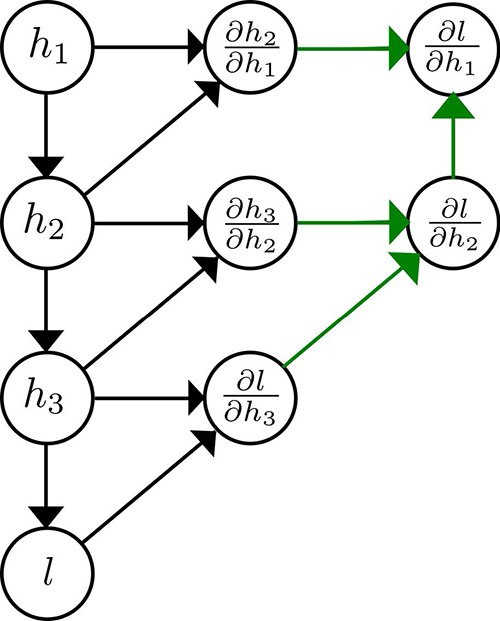

**Note:** Gradient computations are shown in black, application of the chain rule in green
More info about [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/)

## Computational Graphs in TensorFlow

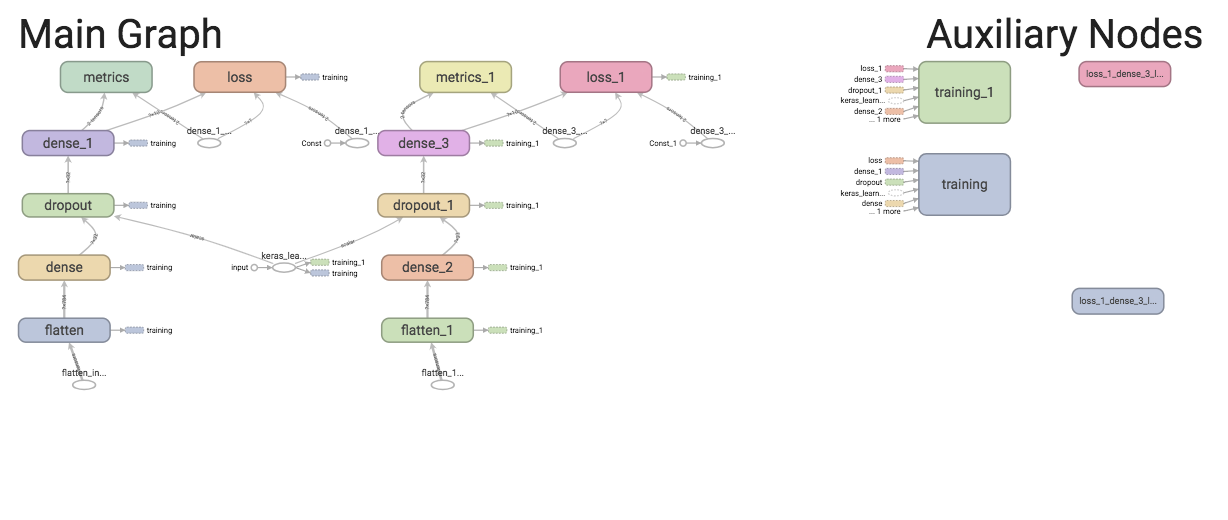

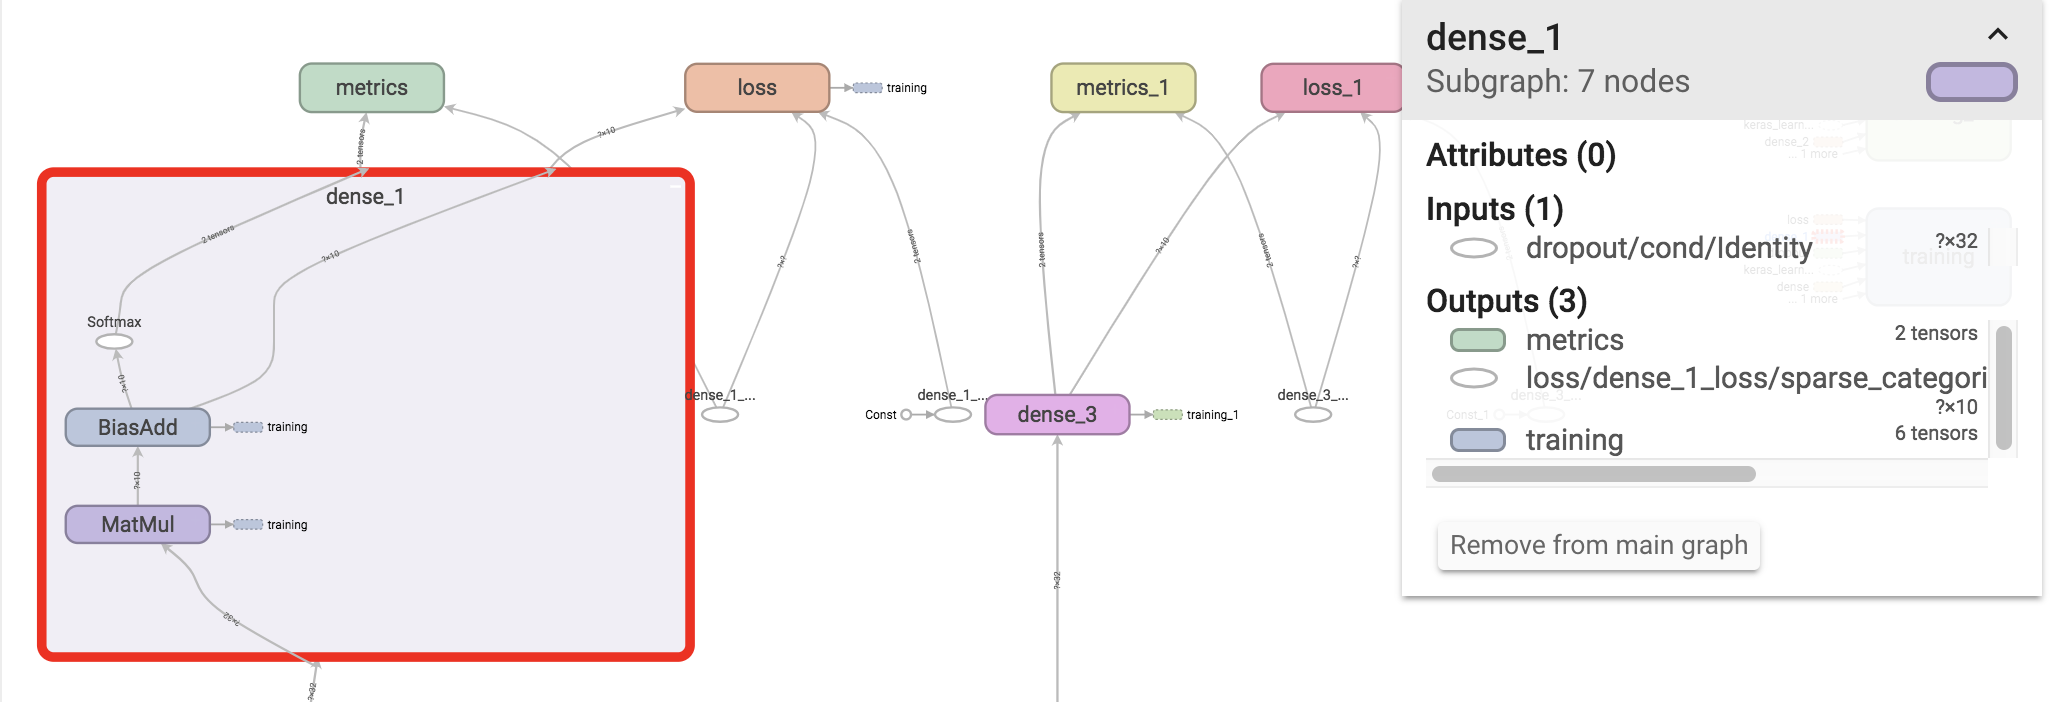

[TensorFlow Documentation] (https://www.tensorflow.org/tensorboard/graphs)

## Cross Validation

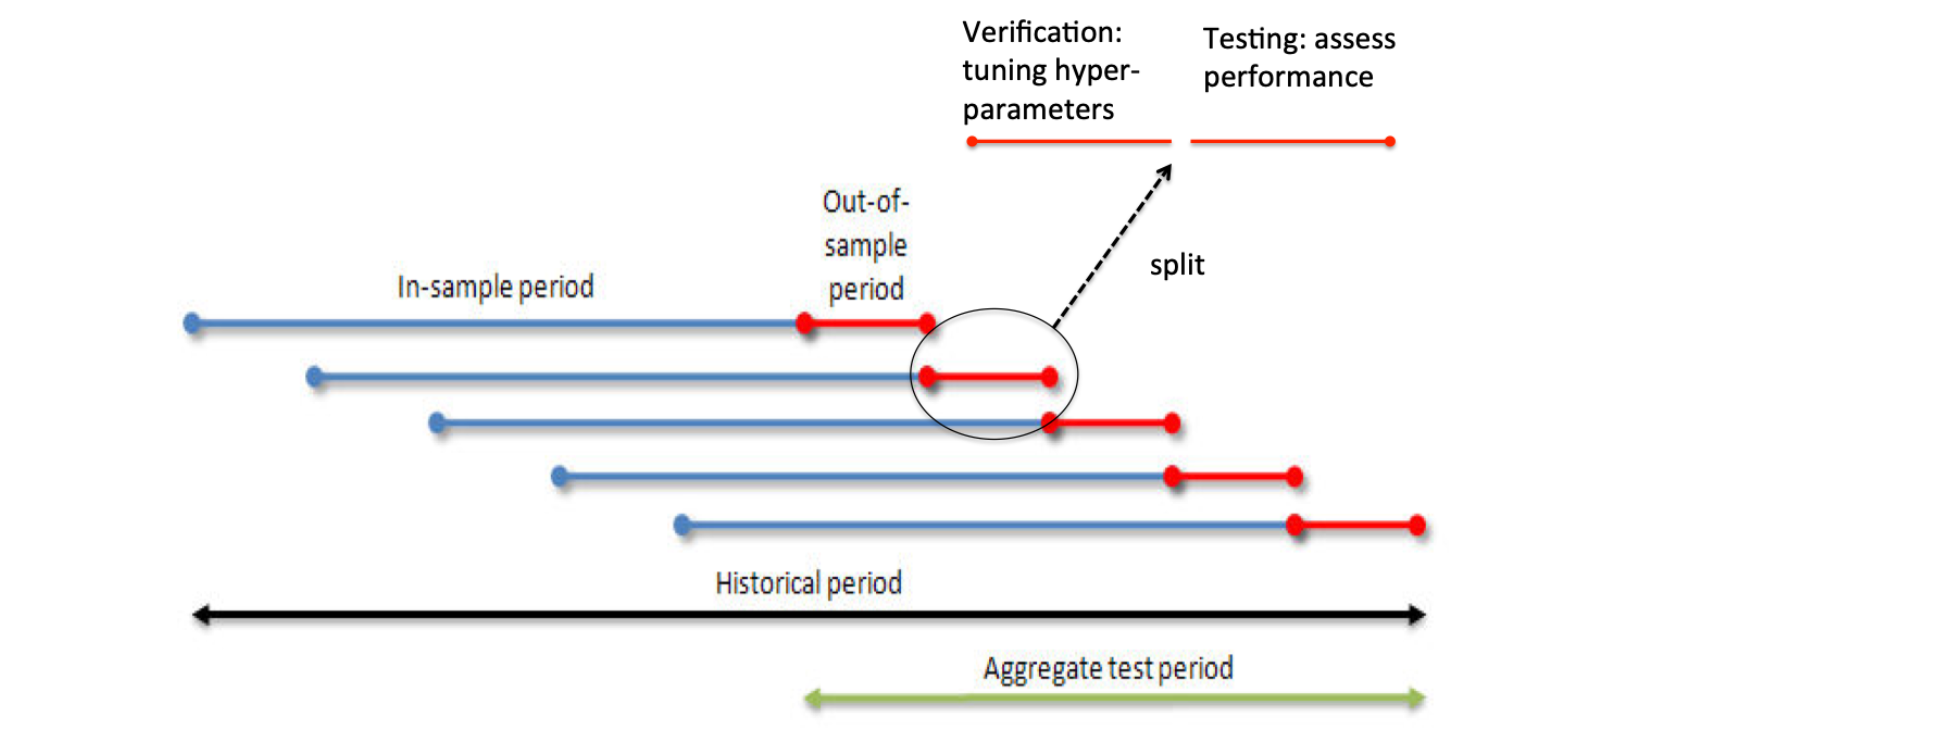

Times series cross validation, also referred to as walk forward optimization, is used instead of standard cross validation to preserve the ordering of the data. This experimental design avoids look-ahead bias in the fitted model which occurs when one or more observations in the training set are from the future.

# About this notebook
The goal of this notebook is to demonstrate how to use `Grid Search CV` and the `scikit learn` wrapper `KerasRegressor` to optimize the hyperparameters of a given model, which here is an **RNN**. Furthermore, this notebook contains examples on how to validate cross-validation. And as a final part, an example is given of how Tensorboard can be used as a callback when training a model and then checking the performance of the model. 
We will use techniques to optimize the training of the network based on the following papers:
- [Practical recommendations for gradient-based training of deep architectures](https://arxiv.org/abs/1206.5533)
- [On the difficulty of training Recurrent Neural Networks](https://arxiv.org/abs/1211.5063)
- [Understanding the exploding gradient problem](https://arxiv.org/abs/1211.5063)
- [Improving neural
networks by preventing co-adaptation of feature](http://arxiv.org/abs/1207.0580)
- [Overfitting in Neural Nets: Backpropagation,
Conjugate Gradient, and Early Stopping](https://proceedings.neurips.cc/paper/2000/file/059fdcd96baeb75112f09fa1dcc740cc-Paper.pdf)
- [Learning curve models and applications: Literature
review and research directions](https://www.sciencedirect.com/science/article/abs/pii/S016981411100062X)
- [Grid Search, Random Search, Genetic Algorithm: A Big Comparison for NAS](https://arxiv.org/abs/1912.06059)

## Vanishing Gradient Problem

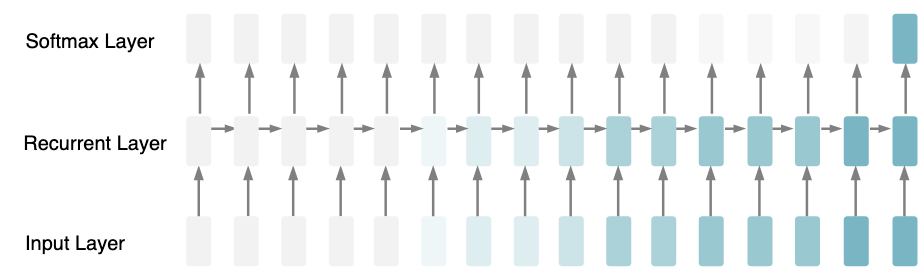

Simplified example of the vanishing gradient problem, where the gradient contribution from earlier steps (left) become insignificant.

## Methods to stabilize the training of RNNs


- __Gradient clipping:__ This method limits the gradient values during backpropagation to prevent them from becoming too large.
- __Initialization strategies:__ Careful initialization of the network parameters can also help to prevent the exploding gradient problem.
- __Layer normalization:__ This technique involves normalizing the activations of each layer in the network, which can help improve the stability and convergence of the training process.
- __Skip and residual connections:__ These connections enable the gradient signal to propa- gate directly through the network without being reduced by activation functions or other transformations. This can prevent gradients from becoming too large or too small, because the network can better propagate the gradient during backpropagation.
- __Adaptive learning rate algorithms:__ Optimizers such as Adam, which use adaptive learning rates for each parameter, can help stabilize the learning process and mitigate the vanishing and exploding gradient problem by adjusting the learning rate based on the magnitude of the gradient. Moreover, by using a moving average of past gradient information, Adam reduces oscillations and improves the stability of the learning process.

## Gradient Clipping - Differentially Private Stochastic Gradient Descent (DP-SGD)

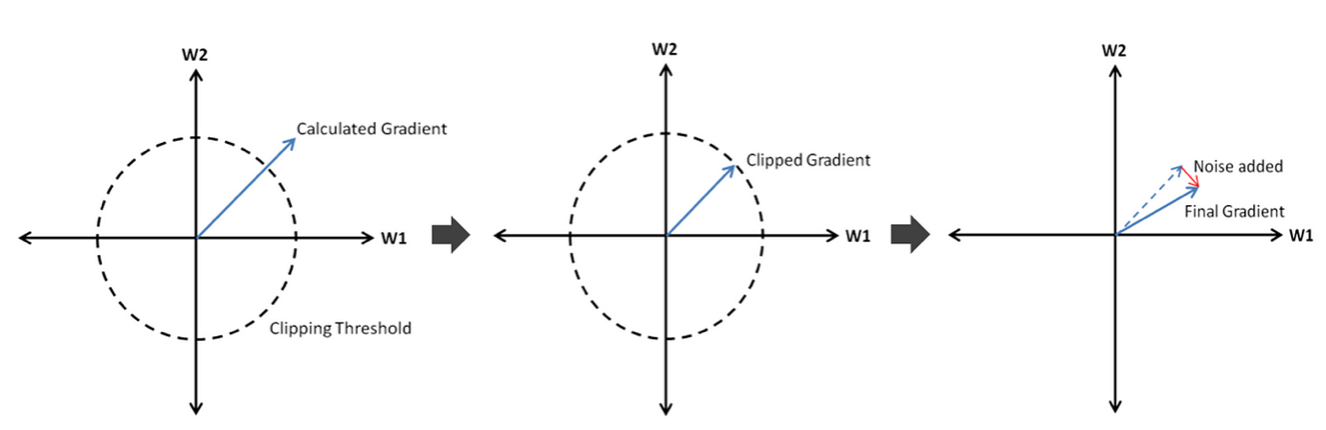

Differential Privacy is a theory which provides us with a certain mathematical guarantee of privacy of user information. It aims to reduce the impact of any one individual’s data on the overall result.

Papers: [Paper 1](https://openreview.net/pdf?id=plu6AK3qs5T), [Paper 2](https://arxiv.org/abs/1607.00133)

<pre>

from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPKerasSGDOptimizer

# Define the DP-SGD optimizer with gradient clipping and noise addition
dp_optimizer = DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=0.05,
    num_microbatches=1,
    learning_rate=0.001
)

# Compile the model with the DP optimizer
model.compile(optimizer=dp_optimizer, loss='mse')

</pre>

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
import time
import random
from datetime import datetime
from importlib import reload
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm


# sklearn imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from scipy.stats import t

# tensorflow and keras imports
import tensorflow.keras.initializers
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.regularizers import l1
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# to make this notebook's output stable across runs
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# surpress scientific notation
pd.options.display.float_format = '{:.8f}'.format

# custom library with functions
py_file_location = '../../'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path

from customlib import model_analysis as ma
from customlib import preprocessing as pre
from customlib import plotting
from customlib import model_analysis as ma

py_file_location = '../../customlib/'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path
# custom bootstrapping class
from bootstrap_ts import BootstrappingWrapper

In [2]:
# imports for plotting
from matplotlib import rcParams
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
matplotlib_axes_logger.setLevel('ERROR')


# global custom setting for the running commands matplotlib or sns
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['scatter.marker'] = 'o'

sns.set_style('whitegrid', {'axes.facecolor': '.995'})

# use the custom style sheet 
plt.style.use('../../custom_plot_style.mplstyle')  

# Computing environment
<a id="Versions" > 

In [3]:
%reload_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,matplotlib,pandas,seaborn


Author: Author: Nicole Königstein

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.1.0
Machine     : arm64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

numpy     : 1.23.5
matplotlib: 3.7.1
pandas    : 1.5.3
seaborn   : 0.12.2



In [4]:
os.system('say "The Model Training has finished"')

0

## Using CPU or GPU

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpu_devices, 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('Using GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('Using CPU')

Using CPU


# Notebook running settings

### Model training

In [6]:
# Set to False if you don't wish to train the models
do_training = True 

### Cross validation

<font color=red><b>WARNING:</b> Changing this to `True` may take many hours to run, depending on your machine.</font>

In [7]:
cross_val = True 

# if the search will be performed in parallel or not, -1 means parallel choose one to not running parallel
n_jobs = -1  

#### Use cross validation data

In [8]:
# which parameters of the cross validation to use for training the model
run_1 = False
run_2 = False

# if cross validation data should be used
use_cv = True

### Training window

In [9]:
n_steps = 21
n_steps_ahead = 1

### Training settings

In [10]:
max_epochs = 2000
batch_size = 128

es = EarlyStopping(monitor='loss', mode='min', verbose=1,
                   patience=10, min_delta=3e-5, restore_best_weights=True)

### Metrics

In [11]:
metrics = ['mse', 'mae']

# Load data

# The Top 25 Stocks in the S&P 500

- Apple (AAPL): 7.14%
- Microsoft (MSFT): 6.1%
- Amazon (AMZN): 3.8%
- Tesla (TSLA): 2.5%
- Alphabet Class A (GOOGL): 2.2%
- Alphabet Class C (GOOG): 2.1%
- NVIDIA Corporation (NVDA): 1.8%
- Berkshire Hathaway Class B (BRK.B): 1.7%
- Meta (META), formerly Facebook, Class A: 1.4%
- UnitedHealth Group (UNH): 1.2%
- Johnson & Johnson (JNJ): 1.2%
- JPMorgan Chase (JPM): 1.0%
- Visa Class A (V): 1.0%


- Procter & Gamble (PG): 1.0%
- Exxon Mobil (XOM): 0.90% 
- Home Depot (HD): 0.8%
- Chevron Corporation (CVX): 0.80%
- Mastercard Inc. Class A (MA): 0.8%
- Bank of America (BAC): 0.8%
- AbbVie Inc. (ABBV): 0.7%
- Pfizer (PFE): 0.7%
- Broadcom Inc. (AVGO): 0.7%
- Costco (COST): 0.7%
- Walt Disney (DIS): 0.7%
- Coca-Cola Company (KO): 0.6%


**Source:** 
By Nathan Reiff, [investopedia.com](https://www.investopedia.com/ask/answers/08/find-stocks-in-sp500.asp) <br>
Updated April 05, 2022 <br>
Reviewed by Chip Stapleton<br>
Fact checked by Vikki Velasquez 

### Datapath

In [12]:
PATH = '../../'

### Get data

In [13]:
ticker = 'AMZN'

In [14]:
df = pd.read_csv(PATH + 'data/stock_prices_25_SP_500.csv')

data = df.loc[df['ticker'] == ticker]


In [15]:
data.head()

ticker        date      close
11992   AMZN  1997-05-16 1.72916667
11993   AMZN  1997-05-19 1.70833333
11994   AMZN  1997-05-20 1.63583333
11995   AMZN  1997-05-21 1.42750000
11996   AMZN  1997-05-22 1.39583333

In [16]:
data = data[['close', 'date']]

# convert date object to datetime
format = '%Y-%m-%d'
data['date'] = pd.to_datetime(data['date'], format=format)
data.set_index('date', inplace=True)


data.head()

close
date                 
1997-05-16 1.72916667
1997-05-19 1.70833333
1997-05-20 1.63583333
1997-05-21 1.42750000
1997-05-22 1.39583333

# Prepare dataset

### Split the dataset

In [17]:
mu, sigma, data_train, data_val, data_test =  pre.prepare_data_val_no_split(data, log_=True)

### Get lagged features

In [18]:
x_train, y_train = pre.get_lagged_dataset(data_train, n_steps, n_steps_ahead)
x_val, y_val = pre.get_lagged_dataset(data_val, n_steps, n_steps_ahead)
x_test, y_test = pre.get_lagged_dataset(data_test, n_steps, n_steps_ahead)

# display the shapes
print([tensor.shape for tensor in (x_train, y_train, x_val, y_val, x_test, y_test)])

[(4099, 21, 1), (4099, 1, 1), (1156, 21, 1), (1156, 1, 1), (568, 21, 1), (568, 1, 1)]


# Model function

In [19]:
init = tf.keras.initializers.glorot_uniform(seed)
recurr_init = tf.keras.initializers.orthogonal(seed)
input_shape = (x_train.shape[1], x_train.shape[-1])  # input lags, features

n_units = 10
l1_reg = 0

# function to create model, which is required for KerasRegressor
def SimpleRNN_(n_units=n_units, l1_reg=l1_reg, dropout_rate=0.5, metrics = ['mse']):
    model = Sequential()
    model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=init,
                        bias_initializer=init, recurrent_initializer=recurr_init,
                        kernel_regularizer=l1(l1_reg), input_shape=input_shape,
                        unroll=True, stateful=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_ahead, kernel_initializer=init, bias_initializer=init,
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam',  metrics=metrics)
    return model


In [20]:
params = {
    'rnn': {
        'model': None, 'network': SimpleRNN_, 'l1_reg': 10, 'n_units': 10,
        'dropout_rate': 0.3, 'color': '#d3d1d1', 'label': 'RNN'},
}

# Load pre-trained models


Training the models may take several hours, depending on your computer. To save time, you may load the already fitted models instead. To do so, just set the param for **Model training** at the beginning of this notebook like this:  `do_training = False`.

In [21]:
folder = 'trained-RNNs/{}/'.format(ticker)
model_name = 'RNNs-{}-{}-{}-conv-SAVED-'.format(ticker, n_steps, n_steps_ahead)
lags = str(n_steps)
                                
if not do_training:
    for key in params.keys():
        print('Loading model weights of {}'.format(key))
        params[key]['model'] = load_model(
            '../trained-RNNs/'+ folder + model_name + key + lags + '.hdf5')

# Cross-validation

In [22]:
# we need to reshape the data to fit the model
y_train = y_train.reshape(-1, n_steps_ahead)

In [23]:
# Define model creation function without defaults
def create_model(n_units, l1_reg, dropout_rate):
    model = Sequential()
    model.add(SimpleRNN(n_units, activation='tanh',
                        kernel_regularizer=l1(l1_reg),
                        input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_ahead,
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

if do_training and cross_val:
    n_units = [5, 10, 20, 30, 40, 50]
    l1_reg = [1e-4, 1e-3, 0.01, 0.1, 0]
    dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

    # a dictionary containing a list of values to be iterated through
    param_grid = dict(model__n_units=n_units, model__l1_reg=l1_reg, model__dropout_rate=dropout_rate)
    
    # TimeSeriesSplit k folds as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits=5)

    # grid search for each param combination
    for key in params.keys():
        networktime = time.time()
        print('Performing cross-validation on model:', key)
        
        model = KerasRegressor(model=params[key]['network'], epochs=max_epochs, batch_size=batch_size, verbose=0)
        
        grid = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=tscv, n_jobs=n_jobs, verbose=3, return_train_score=True)
        
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print('Best score: %f using parameter %s' % (grid_result.best_score_, grid_result.best_params_))
        print('Network Runtime: %0.2f Minutes' % ((time.time() - networktime)/60))
 
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print('%f (%f) with %r' % (mean, stdev, param_))
                
        # Strip off the "model__" prefix
        best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
        params[key].update(best_params)

Performing cross-validation on model: rnn
Fitting 5 folds for each of 150 candidates, totalling 750 fits


2023-07-18 09:49:33.652622: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at resource_variable_ops.cc:597 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.


Best score: 0.989551 using parameter {'model__dropout_rate': 0.3, 'model__l1_reg': 0, 'model__n_units': 30}
Network Runtime: 58.81 Minutes
nan (nan) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.0001, 'model__n_units': 5}
0.984081 (0.009778) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.0001, 'model__n_units': 10}
0.984237 (0.007837) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.0001, 'model__n_units': 20}
0.986585 (0.004436) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.0001, 'model__n_units': 30}
0.986409 (0.005774) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.0001, 'model__n_units': 40}
0.987350 (0.004578) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.0001, 'model__n_units': 50}
0.980137 (0.015393) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.001, 'model__n_units': 5}
0.980938 (0.012419) with {'model__dropout_rate': 0.1, 'model__l1_reg': 0.001, 'model__n_units': 10}
0.979247 (0.016258) with {'model__dropout_rate': 0.1, 'model__l1_re

In [24]:
params[key]

{'model': None,
 'network': <function __main__.SimpleRNN_(n_units=10, l1_reg=0, dropout_rate=0.5, metrics=['mse'])>,
 'l1_reg': 0,
 'n_units': 30,
 'dropout_rate': 0.3,
 'color': '#d3d1d1',
 'label': 'RNN'}

## Save or load the CV results

In [25]:
# which run of the cross validation to use as a basis
if run_1: 
    cv_folder = '{}/run_1/'.format(ticker)
    
elif run_2:
    cv_folder = '{}/run_2/'.format(ticker)

else:
    cv_folder = '{}/'.format(ticker)

print('Using Cross validation from folder: {}'.format(cv_folder))        

Using Cross validation from folder: AMZN/


In [26]:
for key in params.keys():
    
    cv_path = '../../cross_val/'
    
    # save or load the performance metrics from the CV
    file_name = 'cv_results_df-price-{}-{}-n_steps.csv'.format(
        ticker, n_steps)


    if cross_val:
        results_df = pd.DataFrame.from_dict(grid.cv_results_)
        results_df.to_csv(cv_path + cv_folder +
                          key + '_' + file_name, index=None)
    else:
        results_df = pd.read_csv(
            cv_path + cv_folder + key + '_' + file_name)

In [27]:
if not cross_val and use_cv:
    best_results = results_df.sort_values(by='rank_test_score').iloc[0, :]

    for param_key in params[key]:
        if 'param_' + param_key in best_results:
            params[key][param_key] = best_results['param_' + param_key]

            
params_df = pd.DataFrame.from_dict(params)

params_path = '../../params/'
params_folder = '{}/'.format(ticker)

params_file_name = '_params_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)


# save the params    
print('saving params...')
params_df.to_csv(params_path + params_folder + key + params_file_name)            
            
print('Using params: \n')            
pprint(params)           

saving params...
Using params: 

{'rnn': {'color': '#d3d1d1',
         'dropout_rate': 0.3,
         'l1_reg': 0,
         'label': 'RNN',
         'model': None,
         'n_units': 30,
         'network': <function SimpleRNN_ at 0x1730c25f0>}}


# Train models with selected parameters

In [28]:
lags = str(n_steps)

!rm -rf ../../logs/fit/

log_dir = '../../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key
    
    
tf_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Saving figure:  rnn_train_val_los_plot_price_AMZN_n_steps_21_n_steps_ahead_1


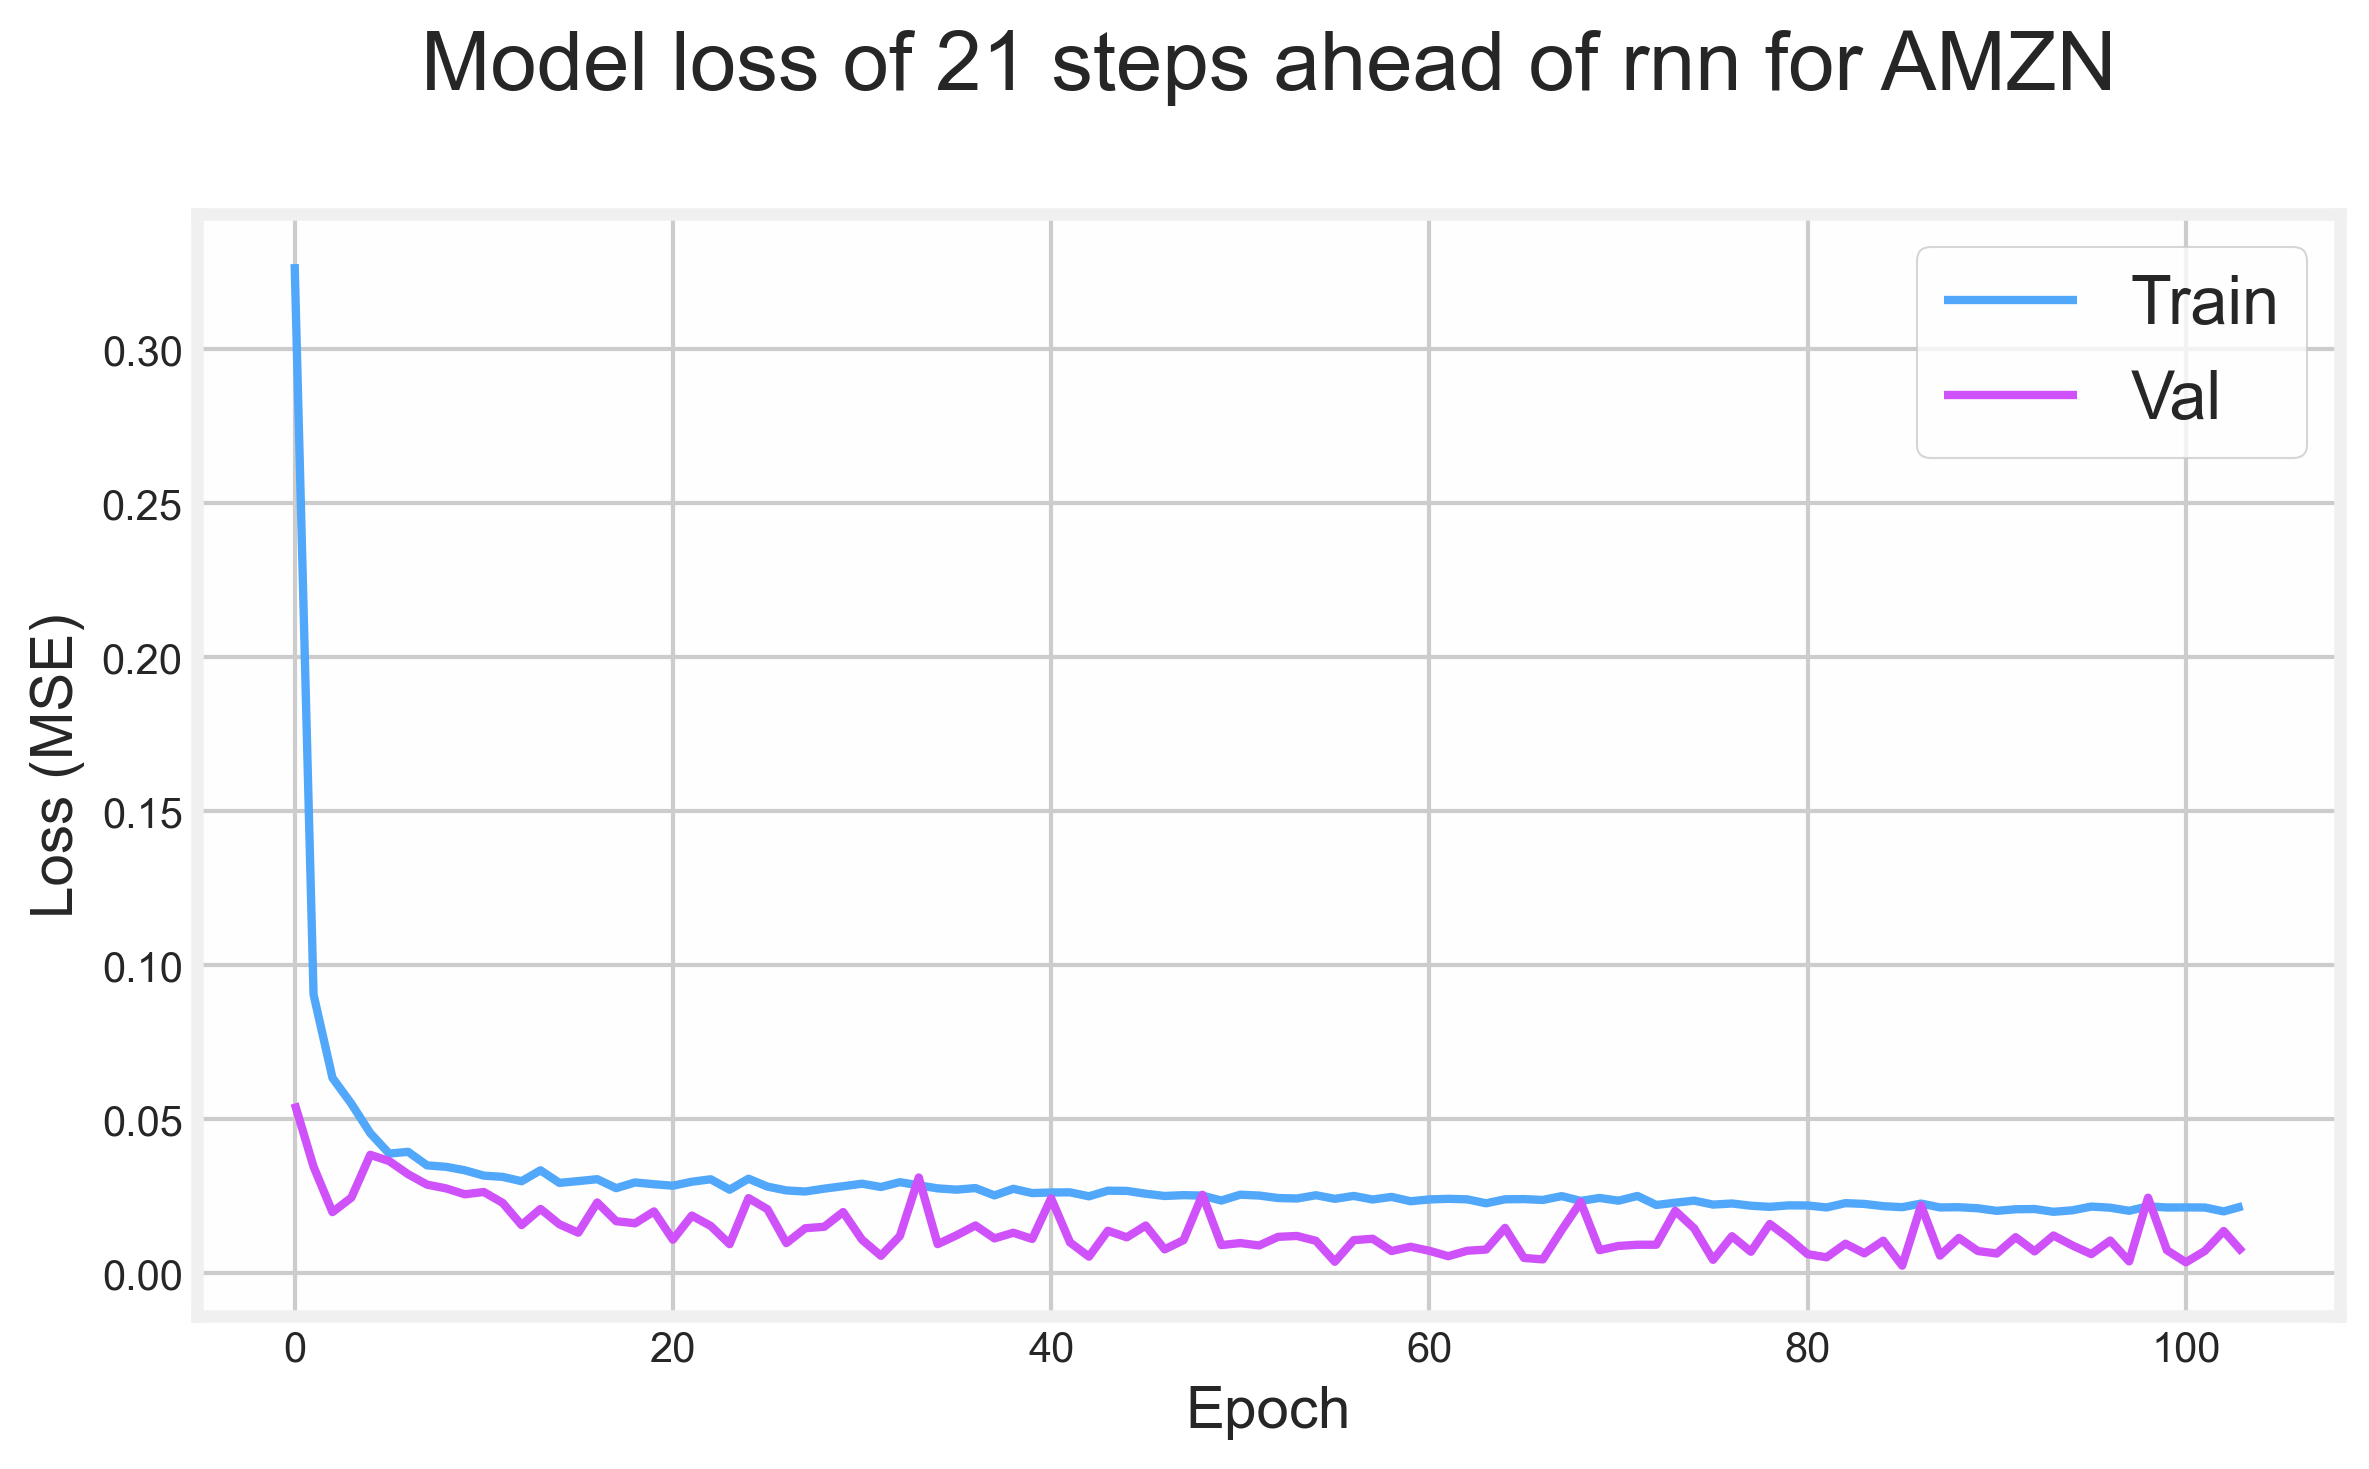

In [30]:
for key in params.keys():
    history = np.load(PATH + hist_folder + history_name +
                      '.npy', allow_pickle='TRUE').item()

    plotting.plot_train_val_loss(
        history, key, ticker, n_steps, n_steps_ahead)

## Save the fitted models

In [31]:
lags = str(n_steps)

if do_training:
    for key in params.keys():
        params[key]['model'].save('../../trained-RNNs/' + folder + model_name + key + lags +
                                  '.hdf5', overwrite=True)

## Prediction

In [32]:
# resahpe data
y_test = y_test.reshape(-1, n_steps_ahead)


In [33]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    params[key]['pred_train'] = model.predict(x_train, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_train steps ahead: ' + str(i+1)] = mean_squared_error(y_train[:, i],
                                                                               params[key]['pred_train'][:, i])
    params[key]['pred_val'] = model.predict(x_val, verbose=True)
    params[key]['pred_test'] = model.predict(x_test, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_test steps ahead:' +
                    str(i+1)] = mean_squared_error(y_test[:, i], params[key]['pred_test'][:, i])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
18/18 [==============================] - 0s 299us/step


In [34]:
# get model performance
compare = params.keys() 

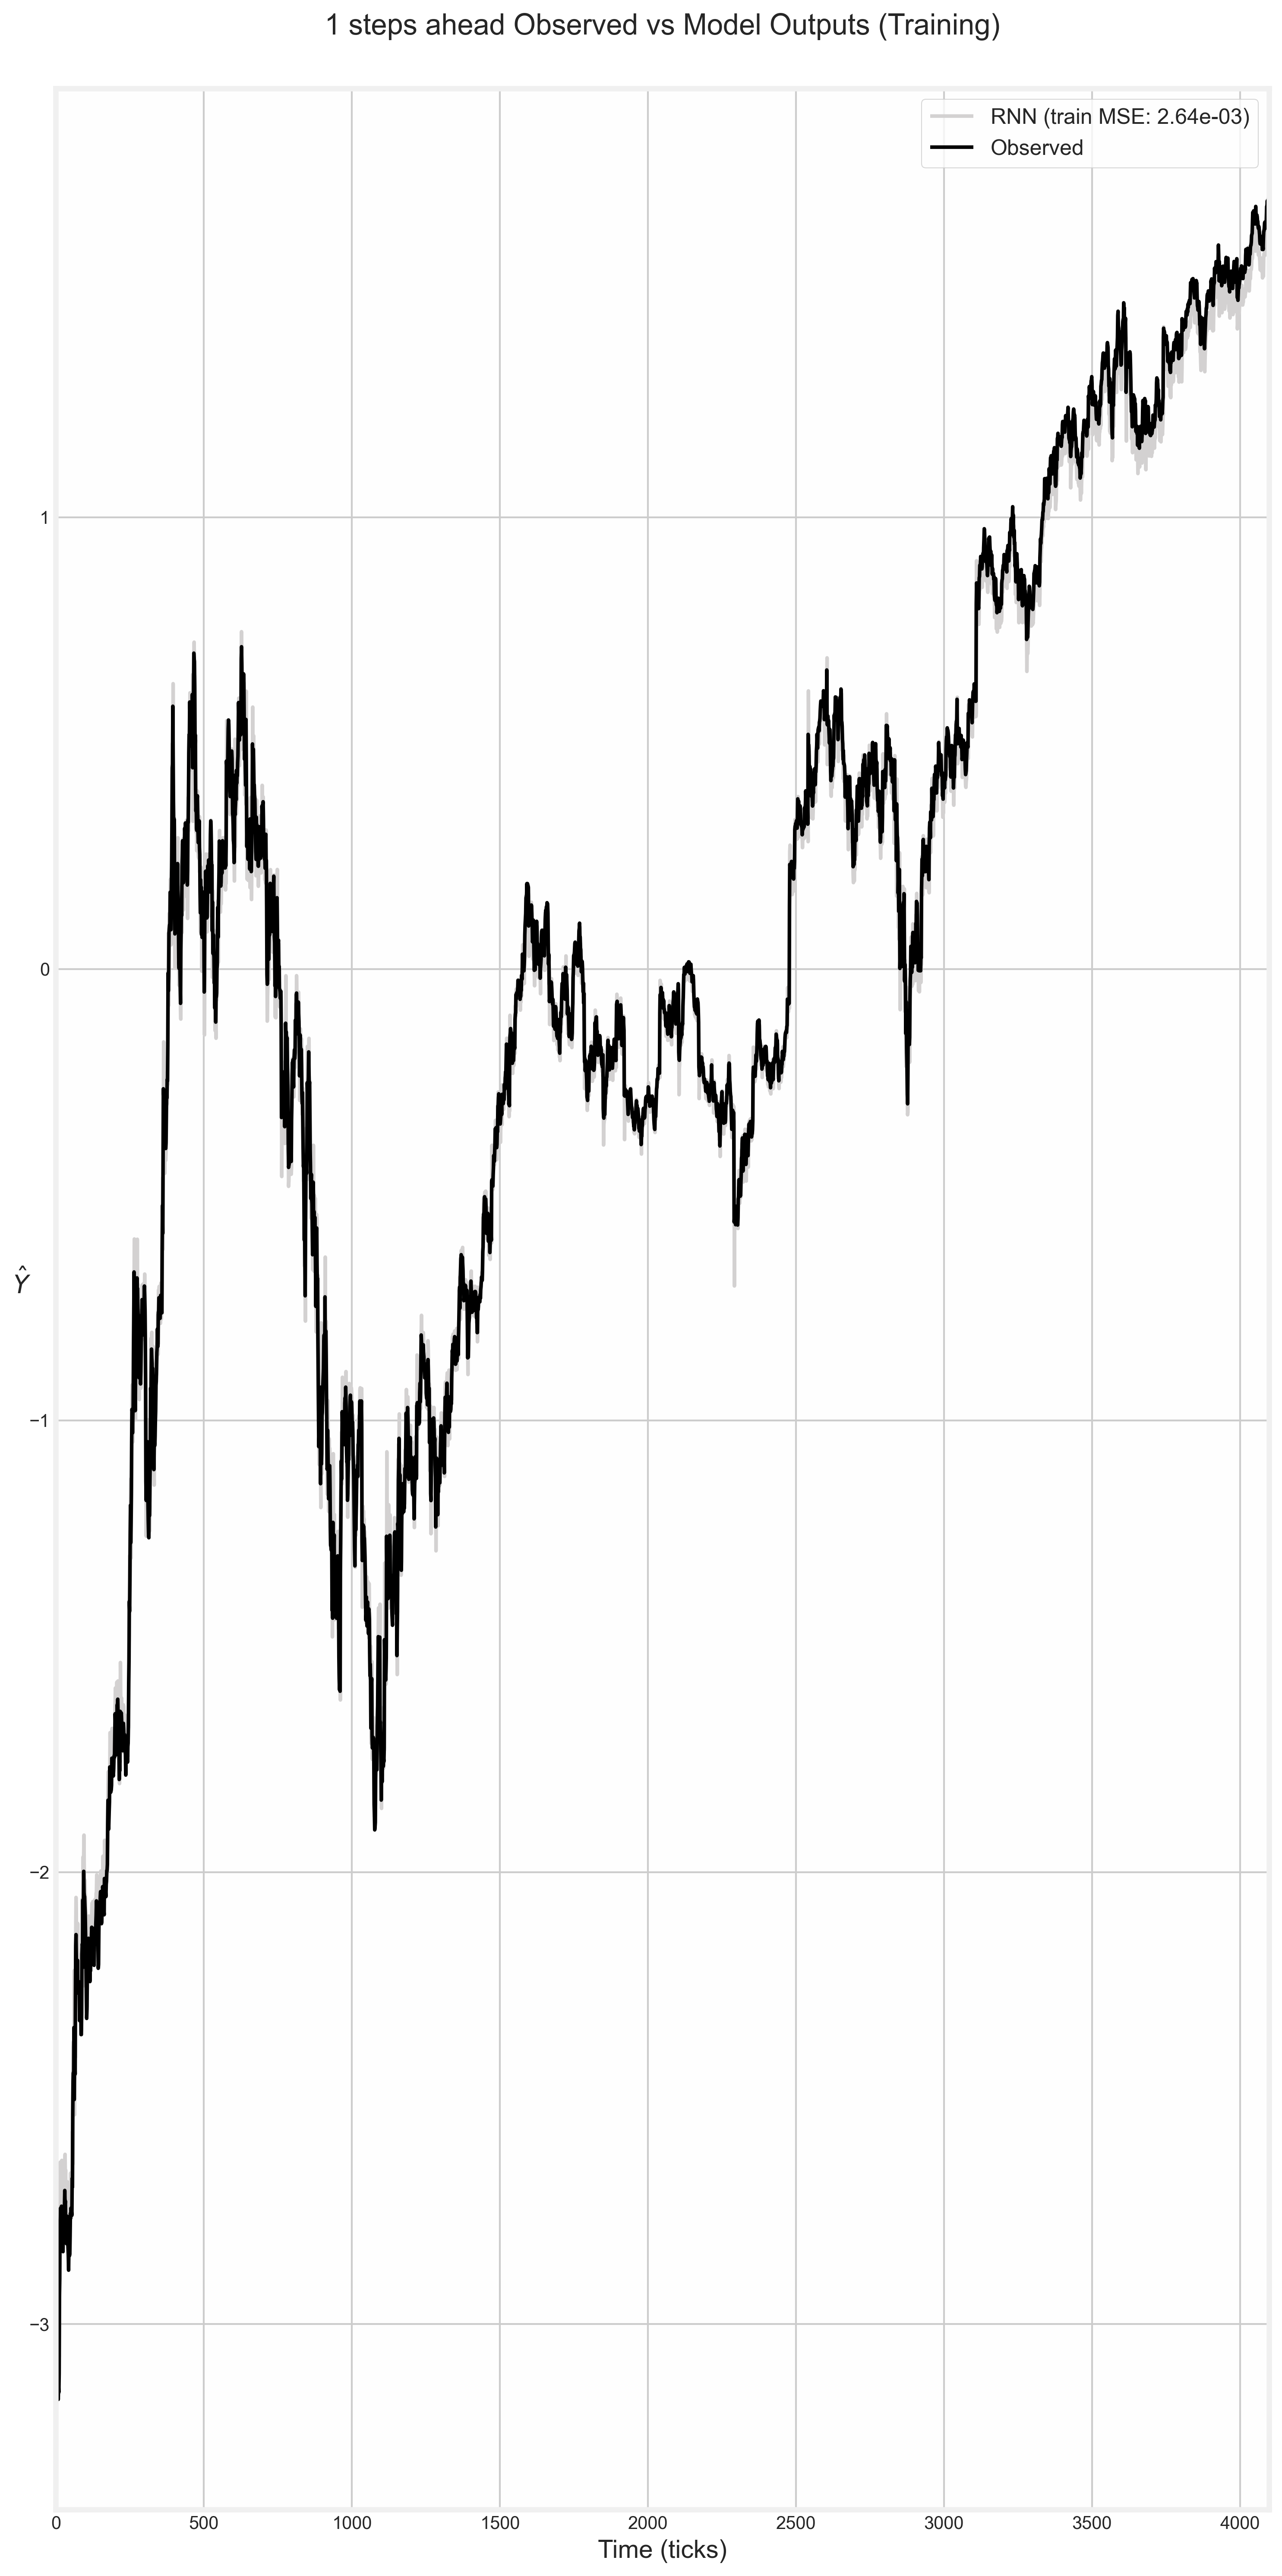

In [35]:
title_train = ' steps ahead Observed vs Model Outputs (Training)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

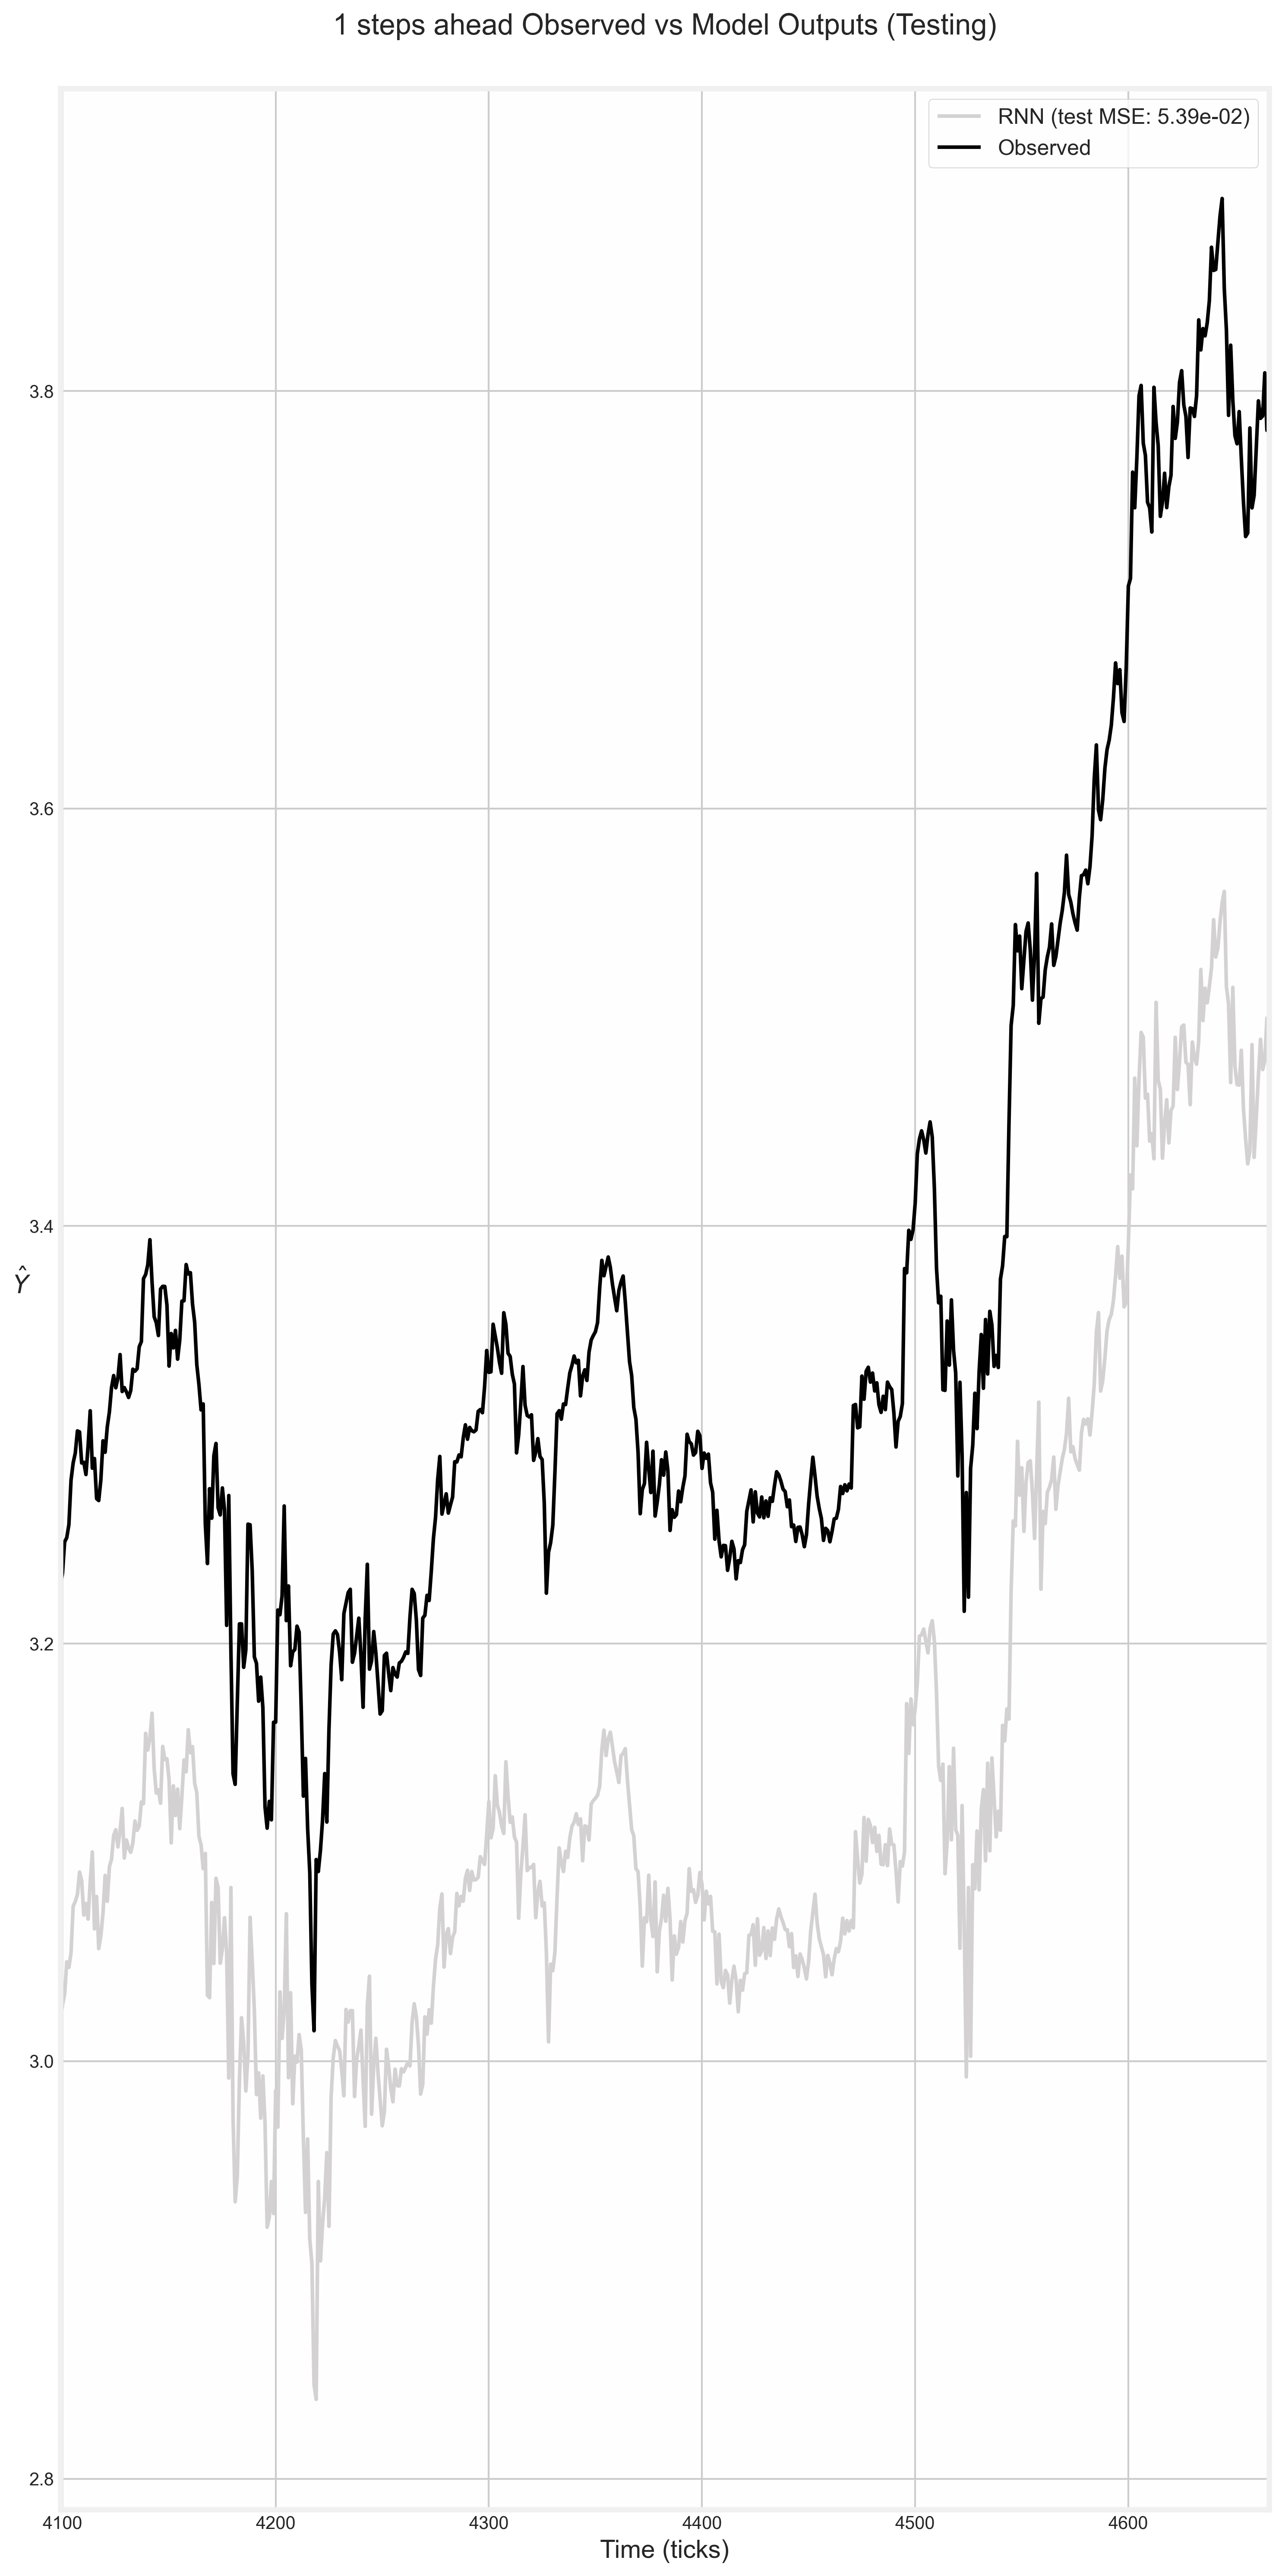

In [36]:
title_test = ' steps ahead Observed vs Model Outputs (Testing)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

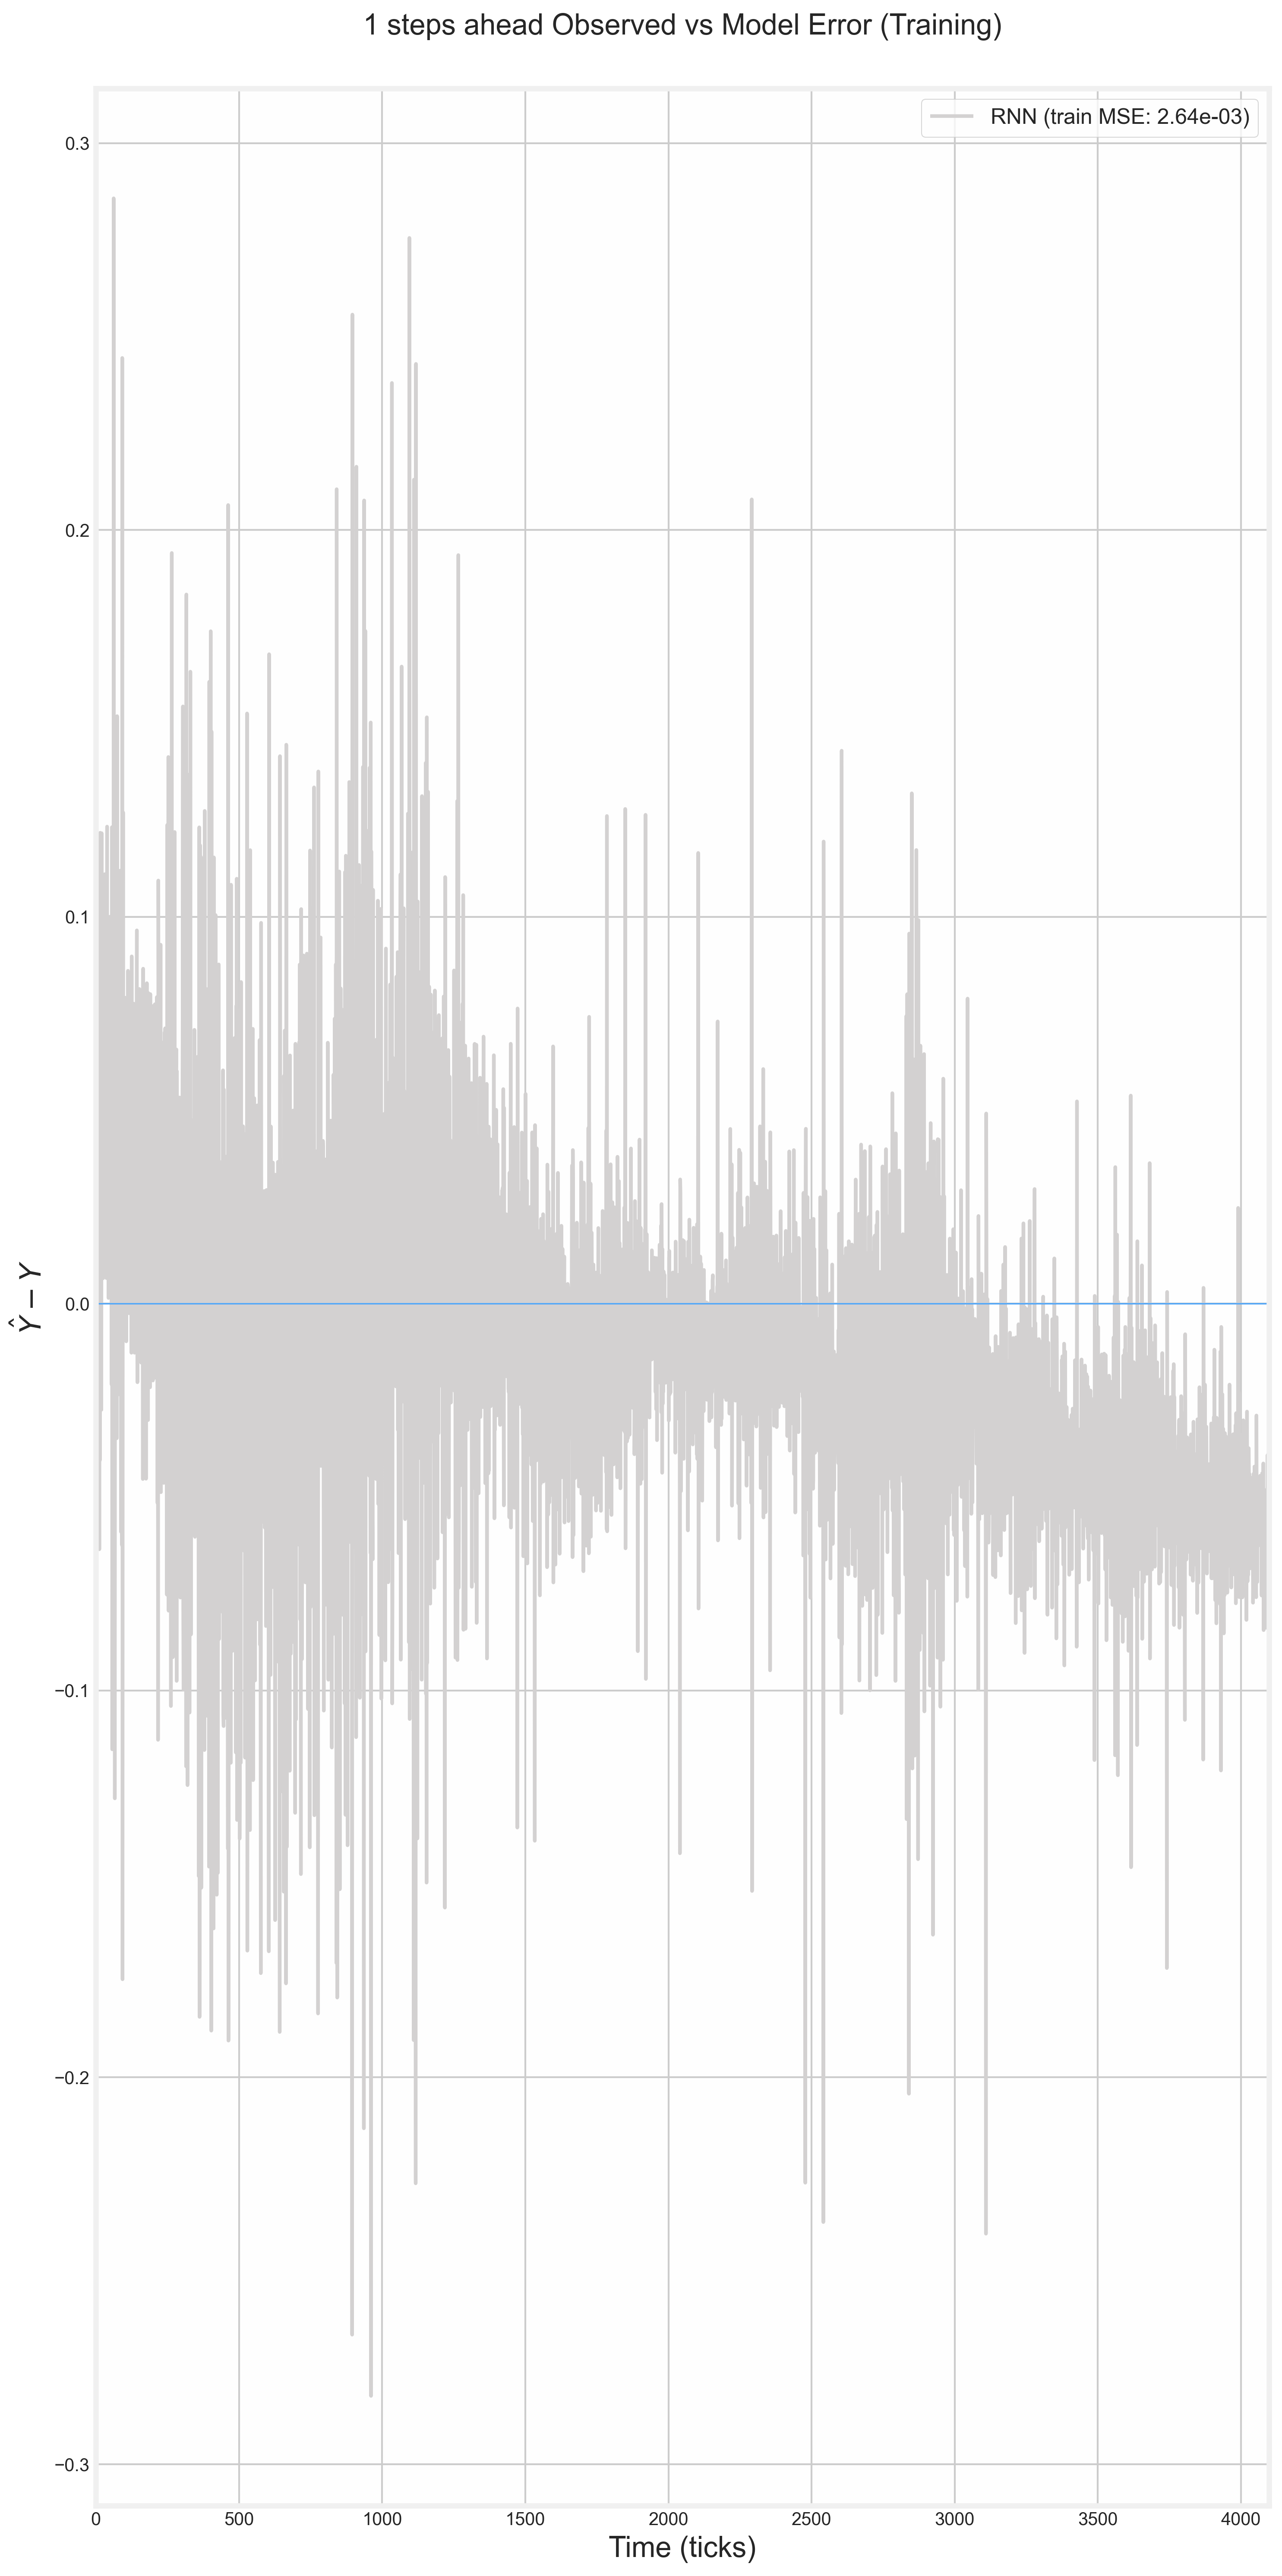

In [37]:
title_train = 'steps ahead Observed vs Model Error (Training)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

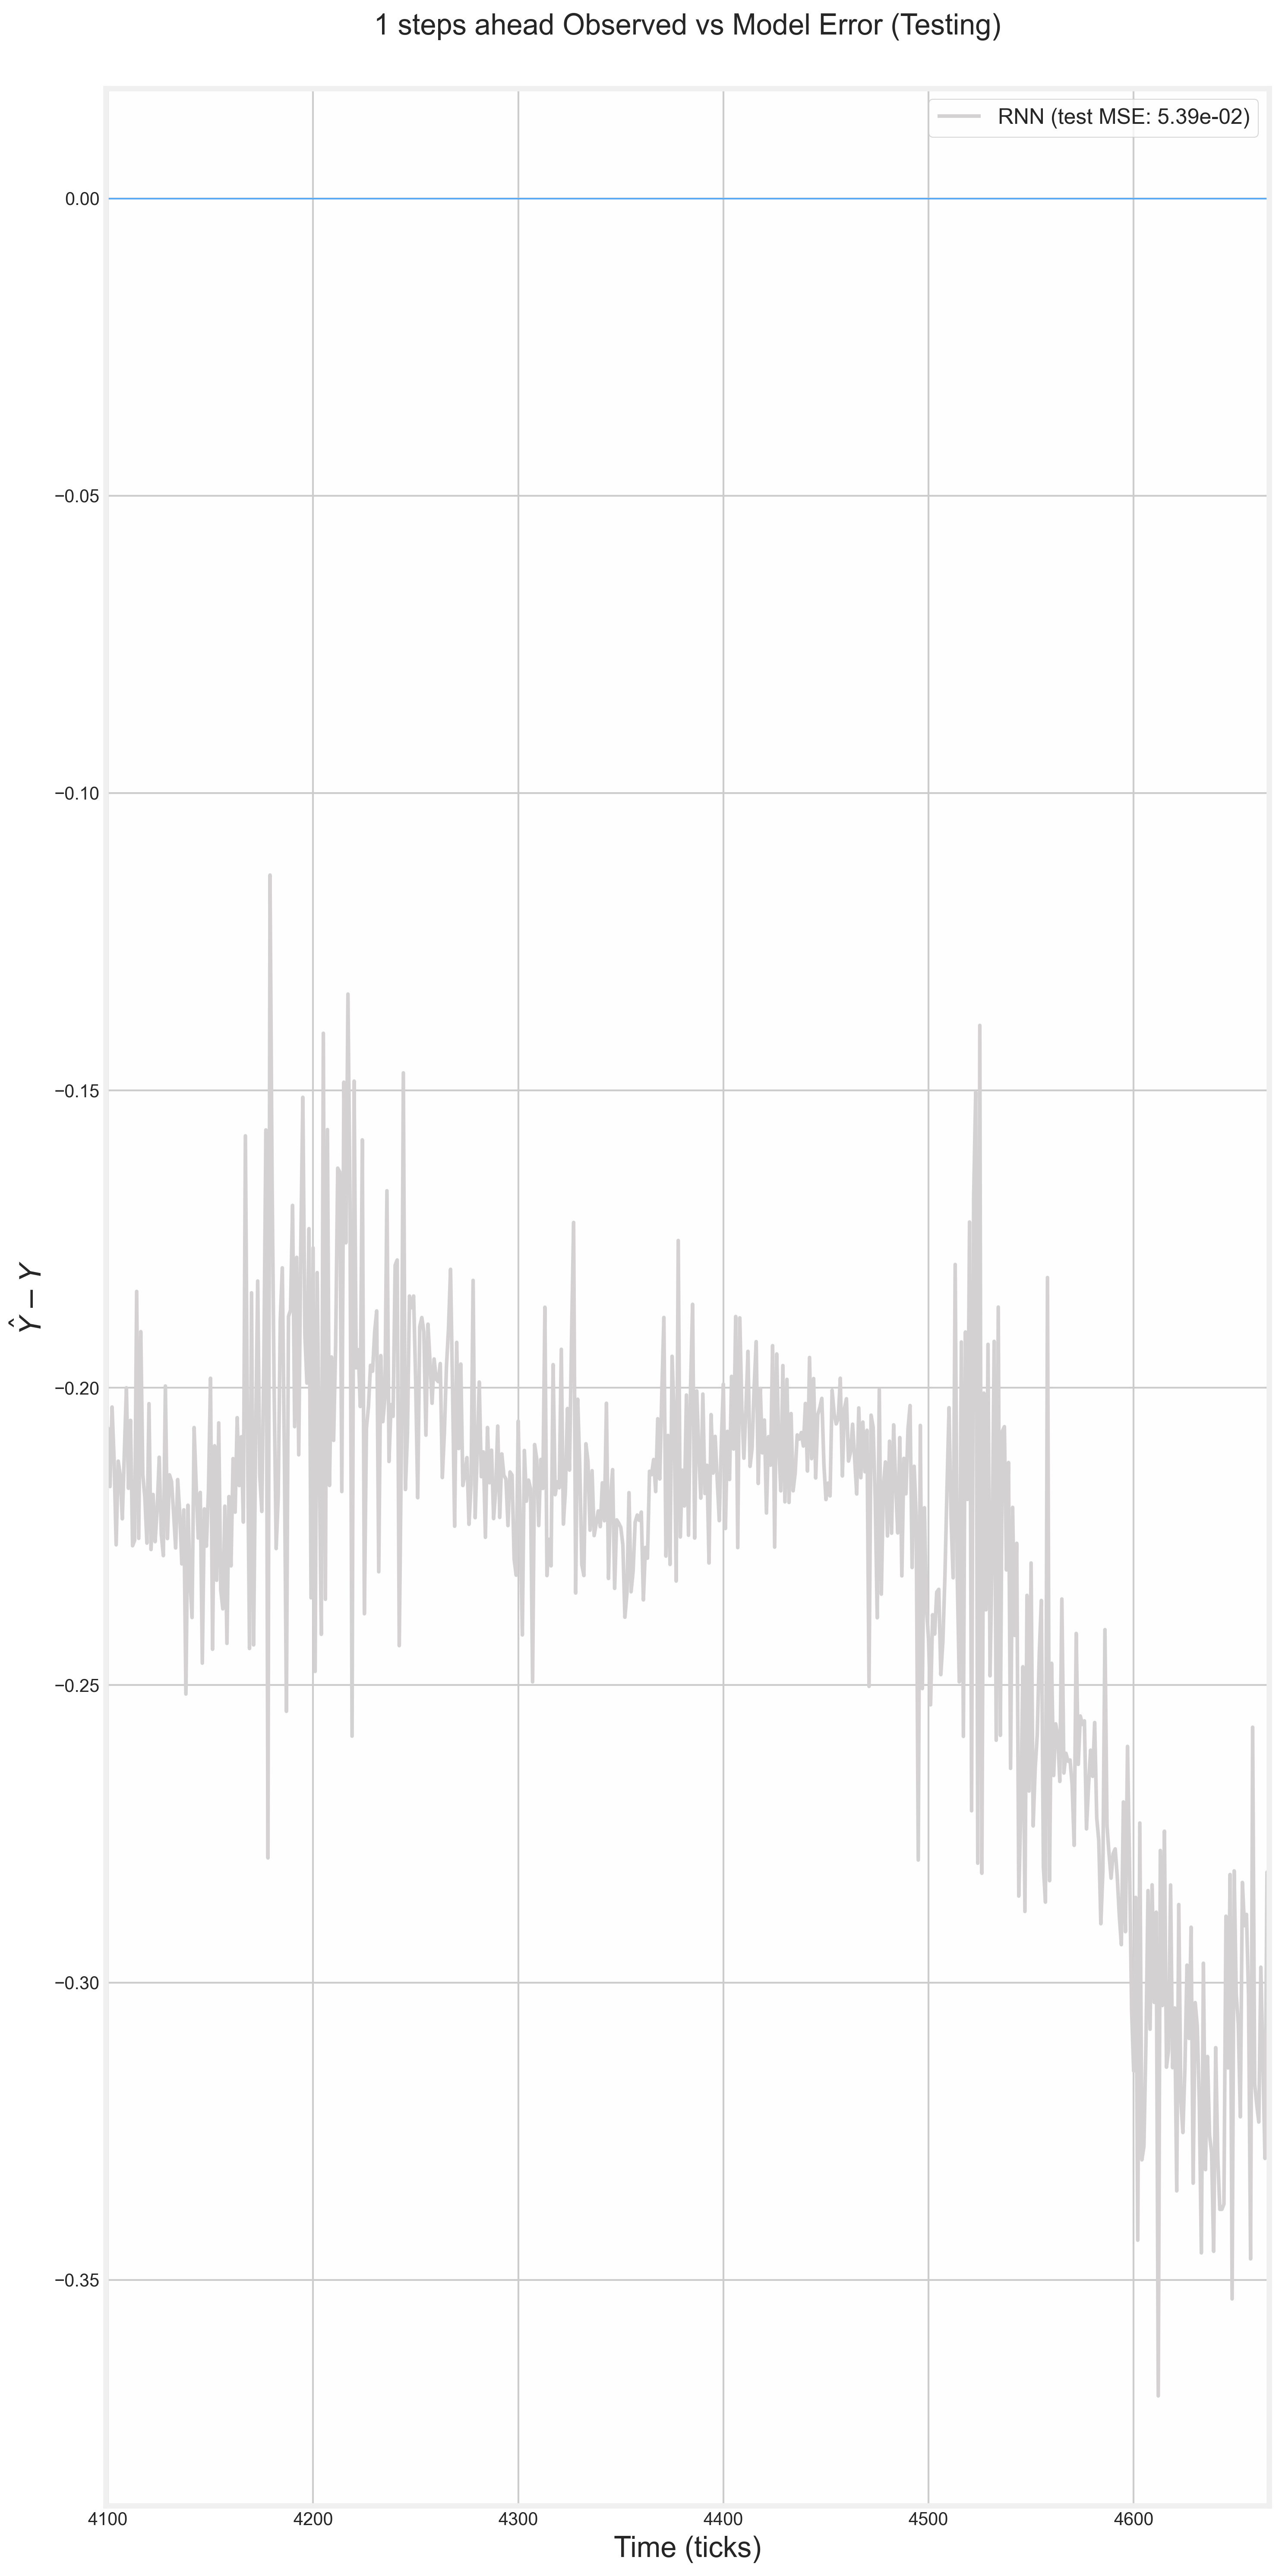

In [38]:
title_test = 'steps ahead Observed vs Model Error (Testing)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

[0.0538854429281802]


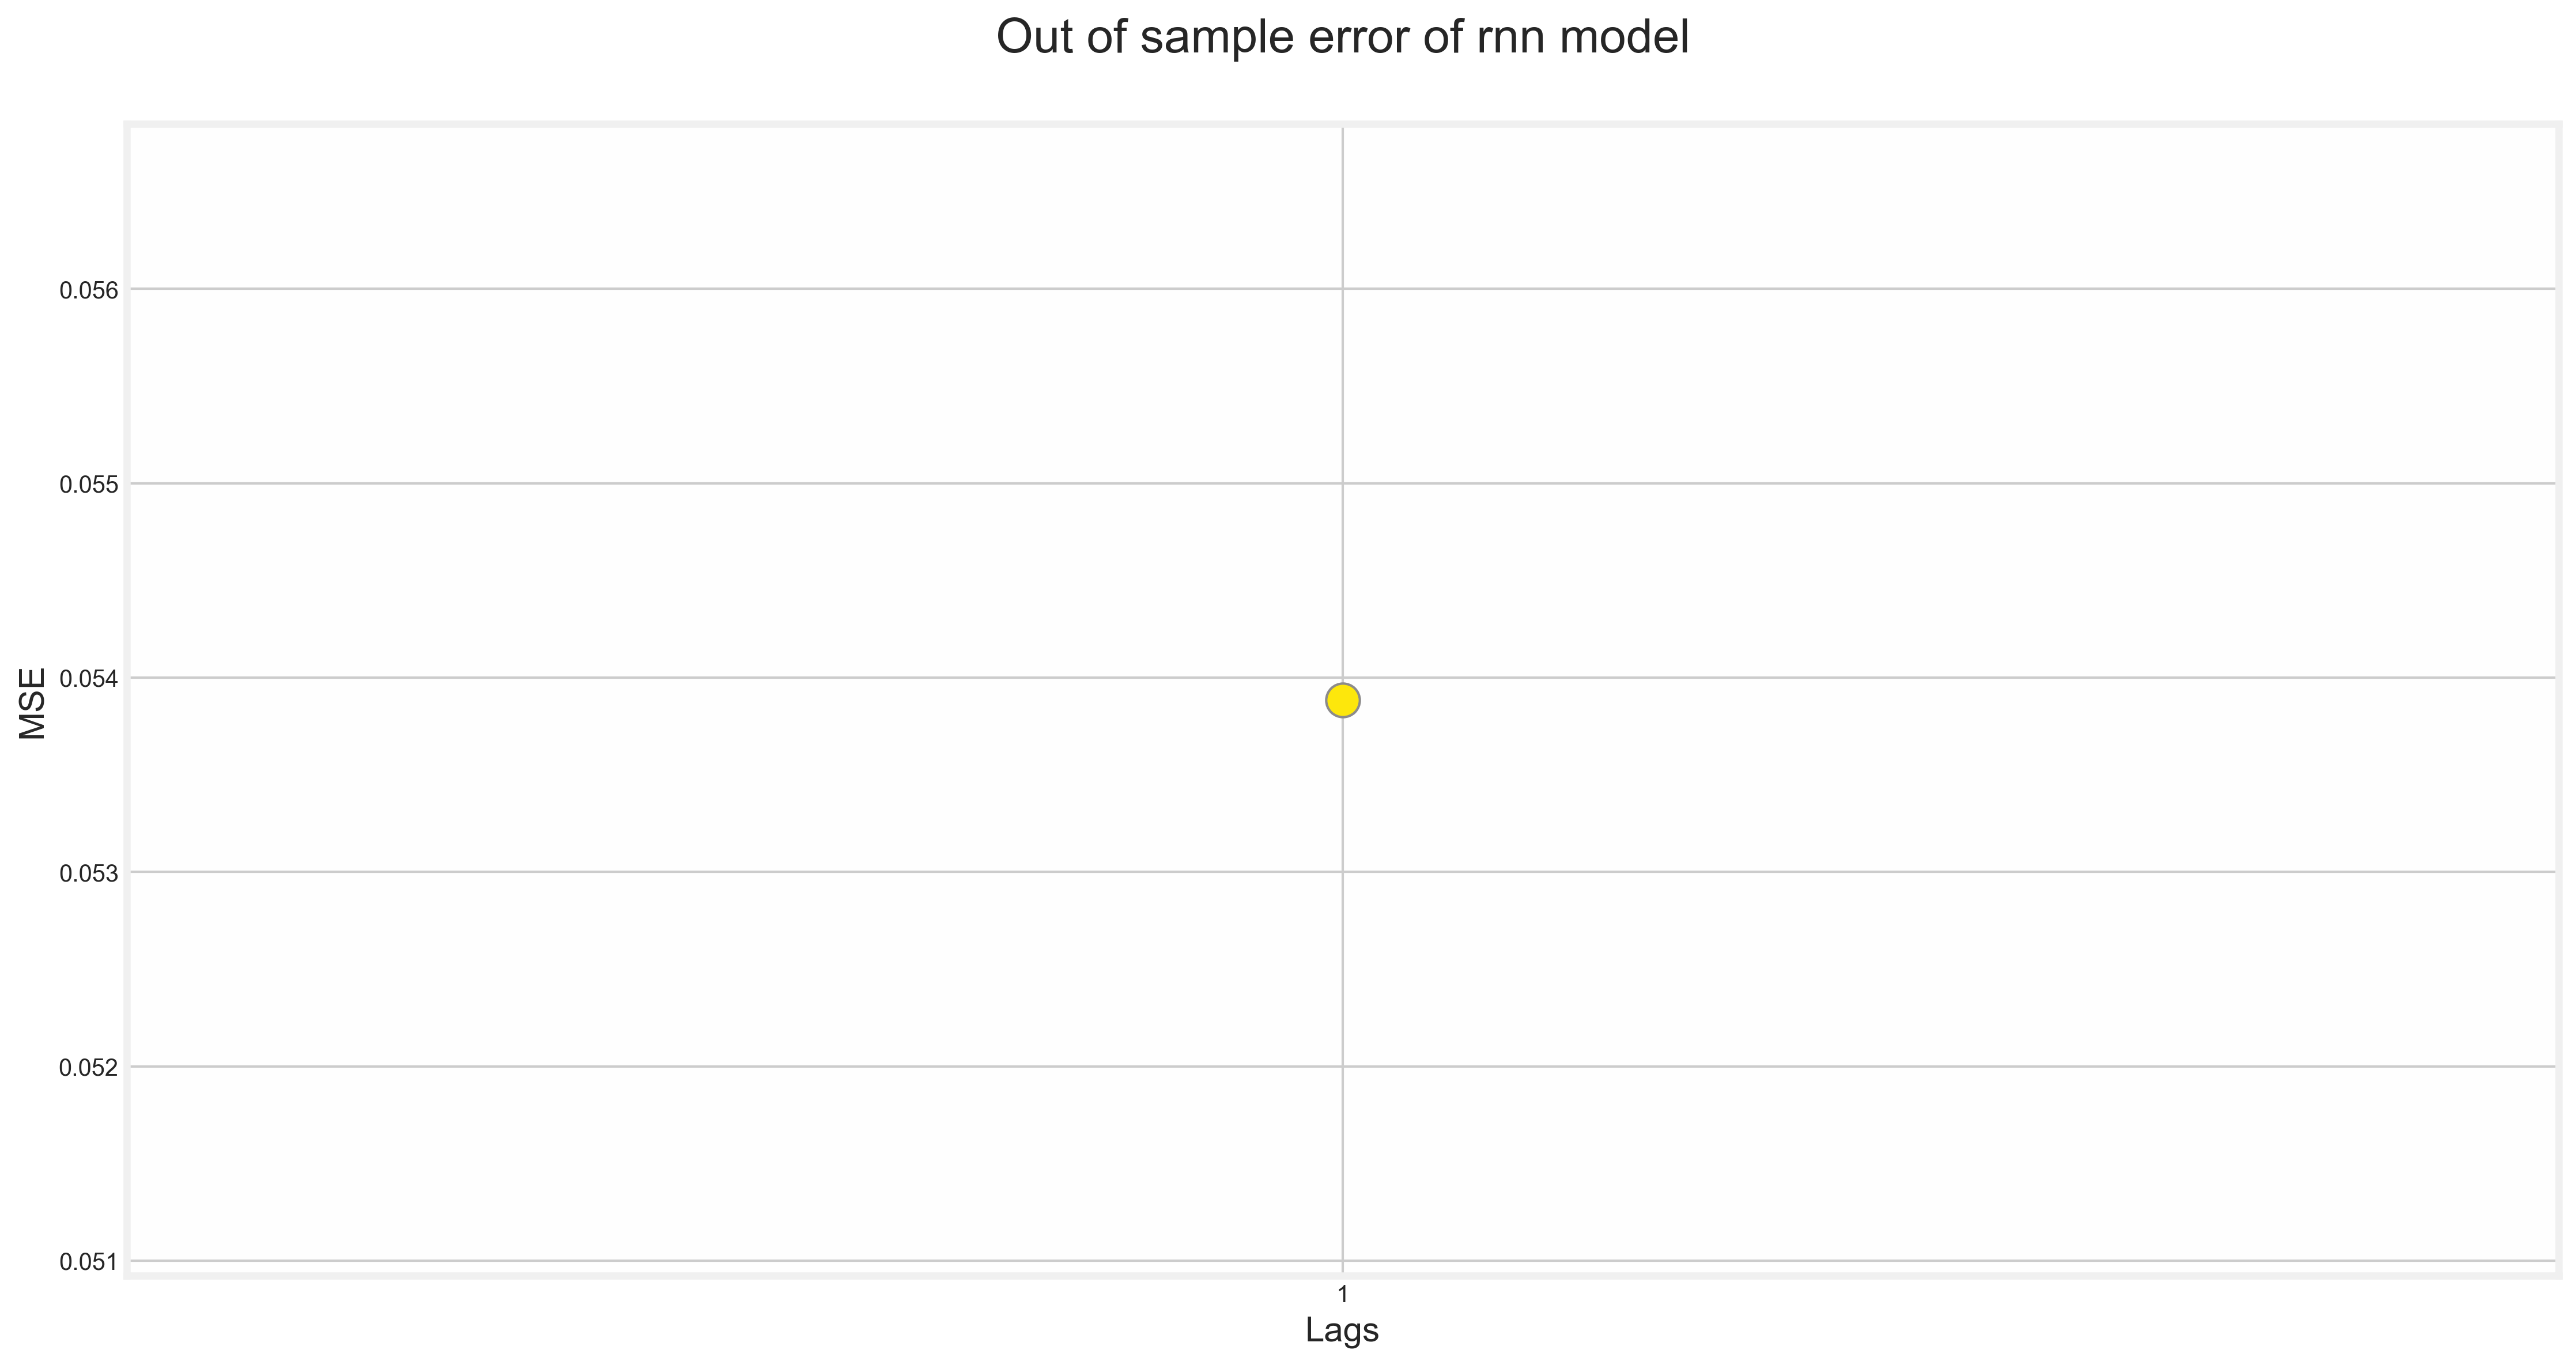

In [39]:
for key in compare:
    plt.figure(figsize=(15, 8))
    title = 'Out of sample error of ' + key + ' model'
    plotting.error_plot(y_test, params[key]['pred_test'], n_steps_ahead, title)

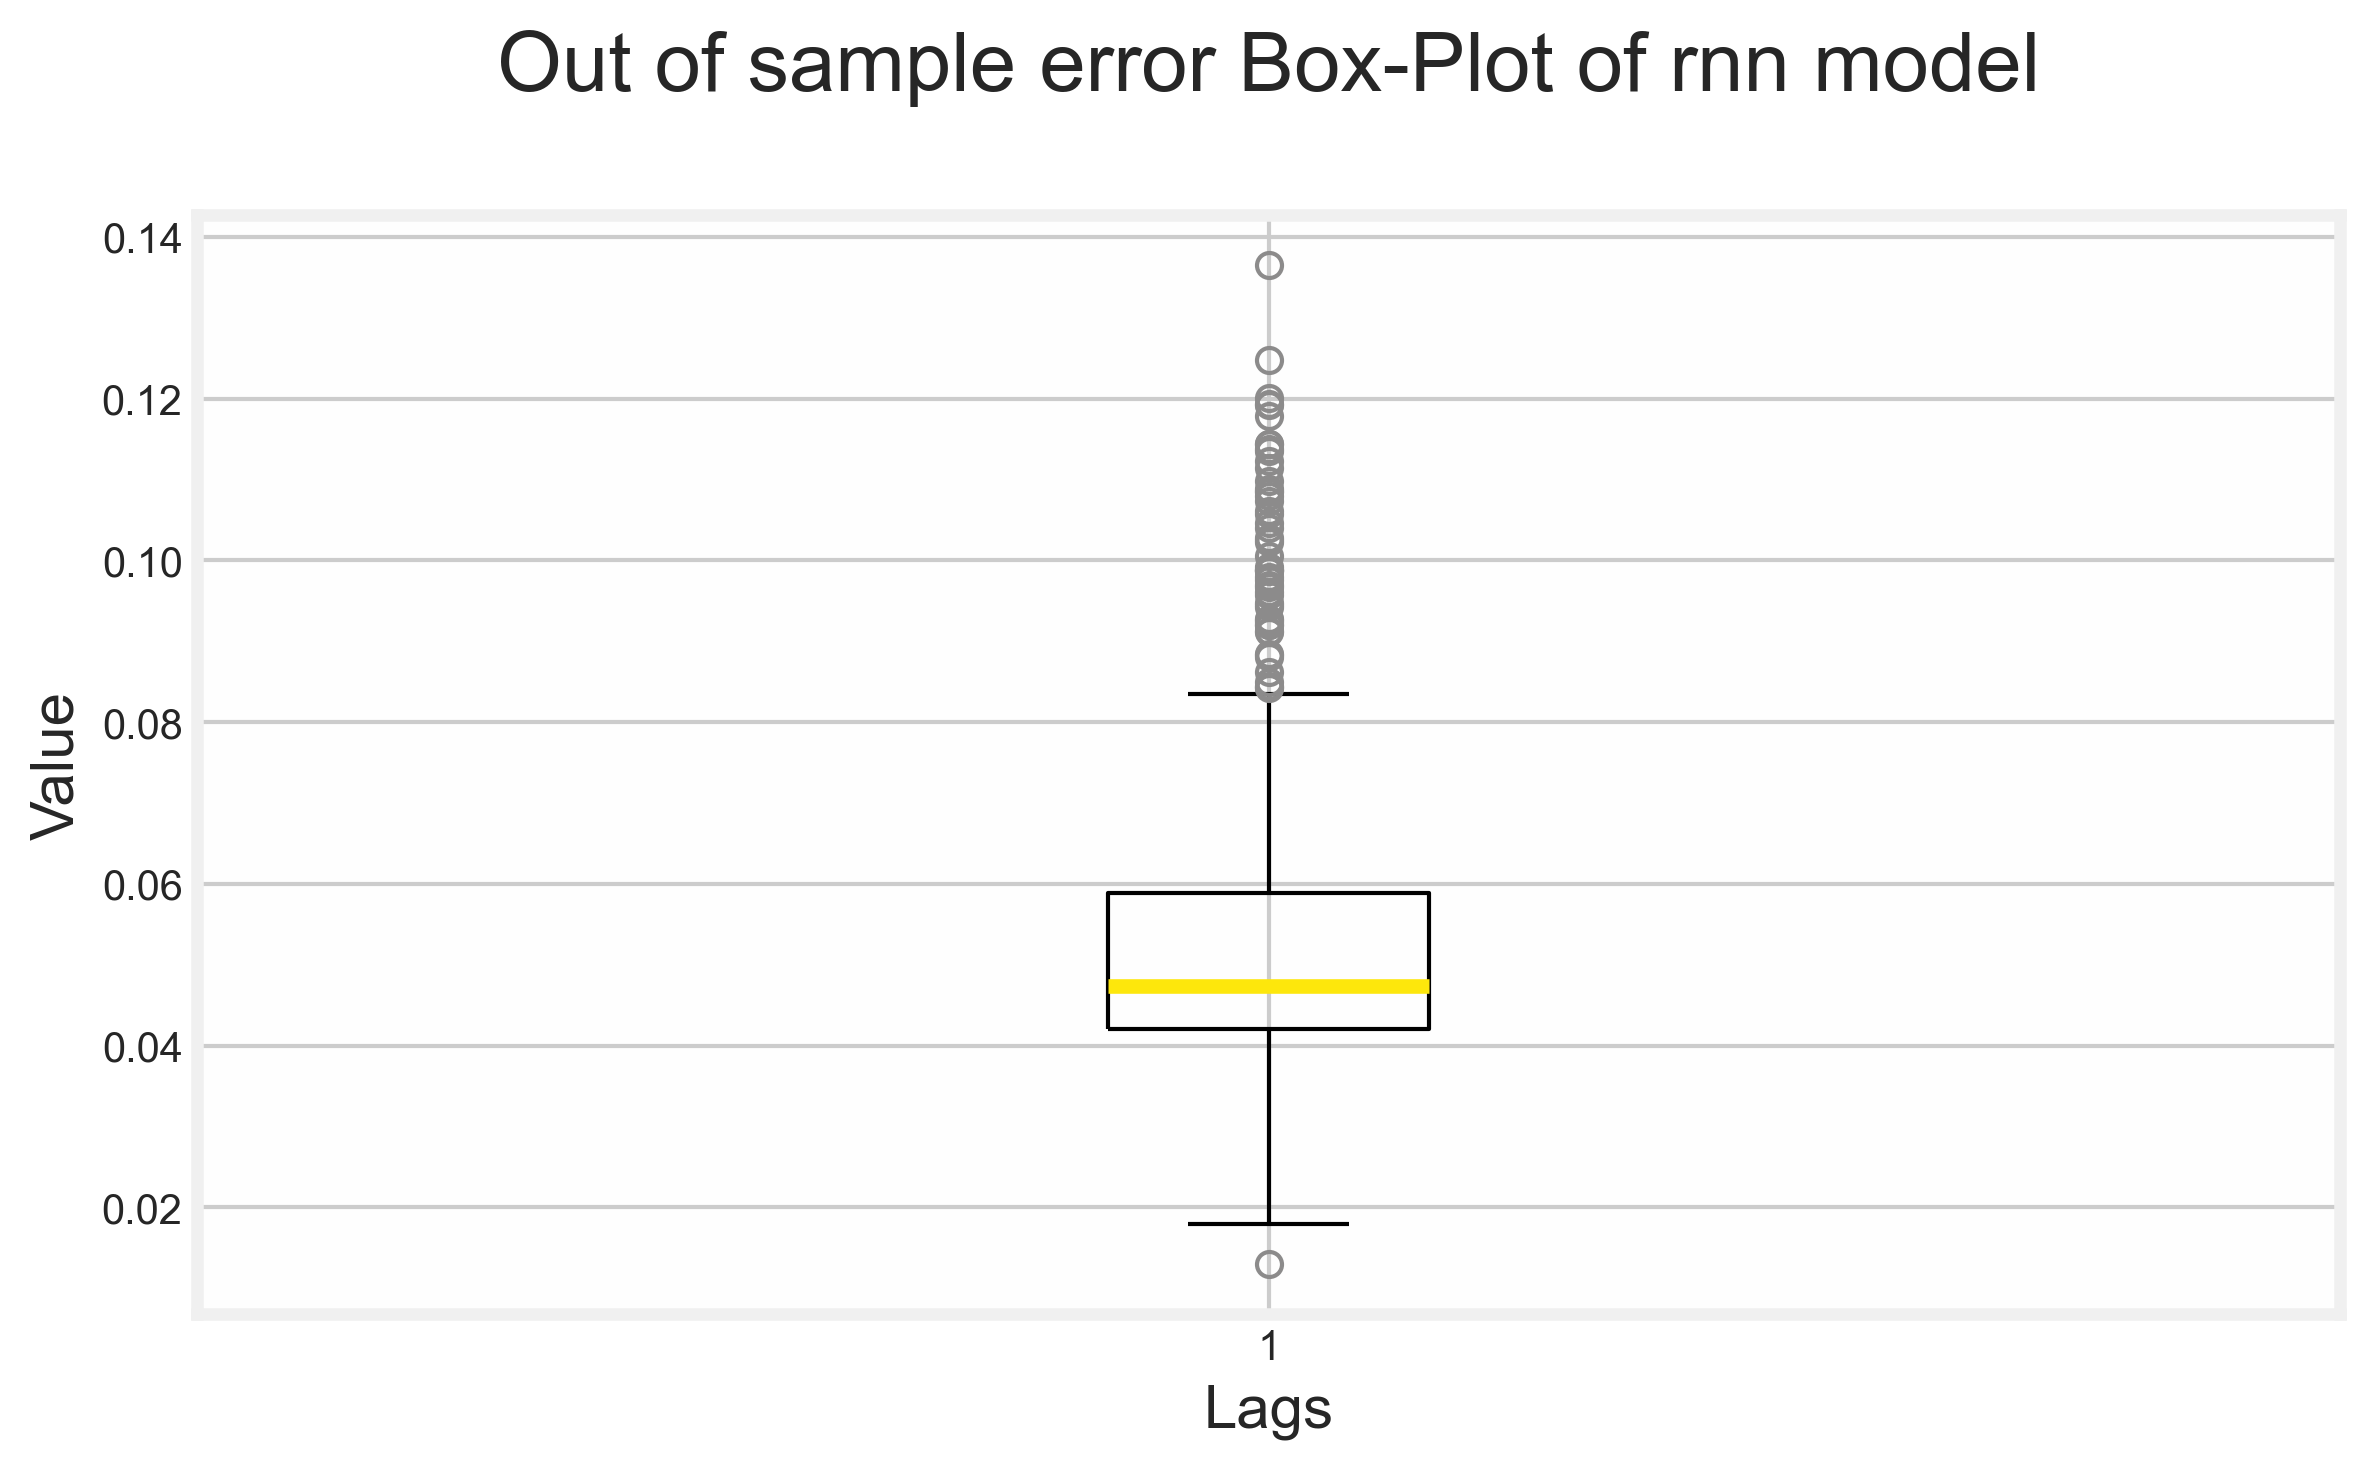

In [40]:
for key in compare:
    title = 'Out of sample error Box-Plot of ' + key + ' model'
    plotting.error_boxplot(
        y_test, params[key]['pred_test'], n_steps_ahead, title)

# Model Diagnostics

## Evaluate model

To gain more insights about the overall performance of the model, we use tensorflow's `evaluate()` function. 

In [41]:
# store the model performance
model_performance = {}

lags = str(n_steps)

# init the names

performance_name_train = key + '_' + ticker + '_' + lags + '_train_price'
performance_name_val = key + '_' + ticker + '_' + lags + '_val_price'
performance_name_test = key + '_' + ticker + '_' + lags + '_test_price'


# eval the model
for key in params.keys():
    model = params[key]['model']
    
    model_performance[performance_name_train] = model.evaluate(x_train, y_train)
    model_performance[performance_name_val] = model.evaluate(x_val, y_val)
    model_performance[performance_name_test] = model.evaluate(x_test, y_test)

    
metrics_evaluate = ma.get_eval_df(model_performance)
metrics_evaluate

18/18 [==============================] - 0s 341us/step - loss: 0.0539 - mse: 0.0539 - mae: 0.2286


MSE        MAE
rnn_AMZN_21_train_price 0.00264159 0.03858261
rnn_AMZN_21_val_price   0.01229019 0.10286199
rnn_AMZN_21_test_price  0.05388544 0.22859292

In [42]:
# save the date frame
evaluate_path = '../../model_evaluate/'
evaluate_folder = '{}/'.format(ticker)

evaluate_file_name = '_evaluate_df-price-{}-{}-n_steps.csv'.format(
    ticker, n_steps)


metrics_evaluate.to_csv(
    evaluate_path + evaluate_folder + key + evaluate_file_name)

## Grid search

We can use Bayesian estimation to calculate the probability that the first model is better than the second. Bayesian estimation will output a distribution followed by the mean $\mu$ of the differences in the performance of two models.
Marginalizing out the variance from this normal posterior, we can define the posterior of the mean parameter as a Student’s t-distribution. Specifically:

$$
S t\left(\mu ; n-1, \bar{x},\left(\frac{1}{n}+\frac{n_{\text {test }}}{n_{\text {train }}}\right) \hat{\sigma}^{2}\right),
$$

where $n$ is the total number of samples, $\bar{x}$ represents the mean difference in the scores, $n_{test}$ is the number of samples used for testing, $n_{train}$ is the number of samples used for training, and $\hat{\boldsymbol{\sigma}}^{2}$ represents the variance of the observed differences.

**Note:** We are using [Nadeau and Bengio’s corrected variance](https://proceedings.neurips.cc/paper/1999/file/7d12b66d3df6af8d429c1a357d8b9e1a-Paper.pdf) in our Bayesian approach.

More information on [Statistical comparison of models using grid search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html)

In [43]:
model_scores = results_df.filter(regex=r'split\d*_test_score')
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores
tscv = TimeSeriesSplit(n_splits=5)

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(tscv.split(x_train, y_train))[0][0])
n_test = len(list(tscv.split(x_train, y_train))[0][1])

t_stat, p_val = ma.compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\n"
      f"Corrected p-value: {p_val:.3f}")

Corrected t-value: nan
Corrected p-value: nan


In [44]:
t_stat_uncorrected = (
    np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
      f"Uncorrected p-value: {p_val_uncorrected:.3f}")


Uncorrected t-value: nan
Uncorrected p-value: nan


In [45]:
# intitialize random variable
t_post = t(
    df, loc=np.mean(differences),
    scale=ma.corrected_std(differences, n_train, n_test)
)

Saving figure:  post_dist_plot_price_AMZN_n_steps_21_n_steps_ahead_1


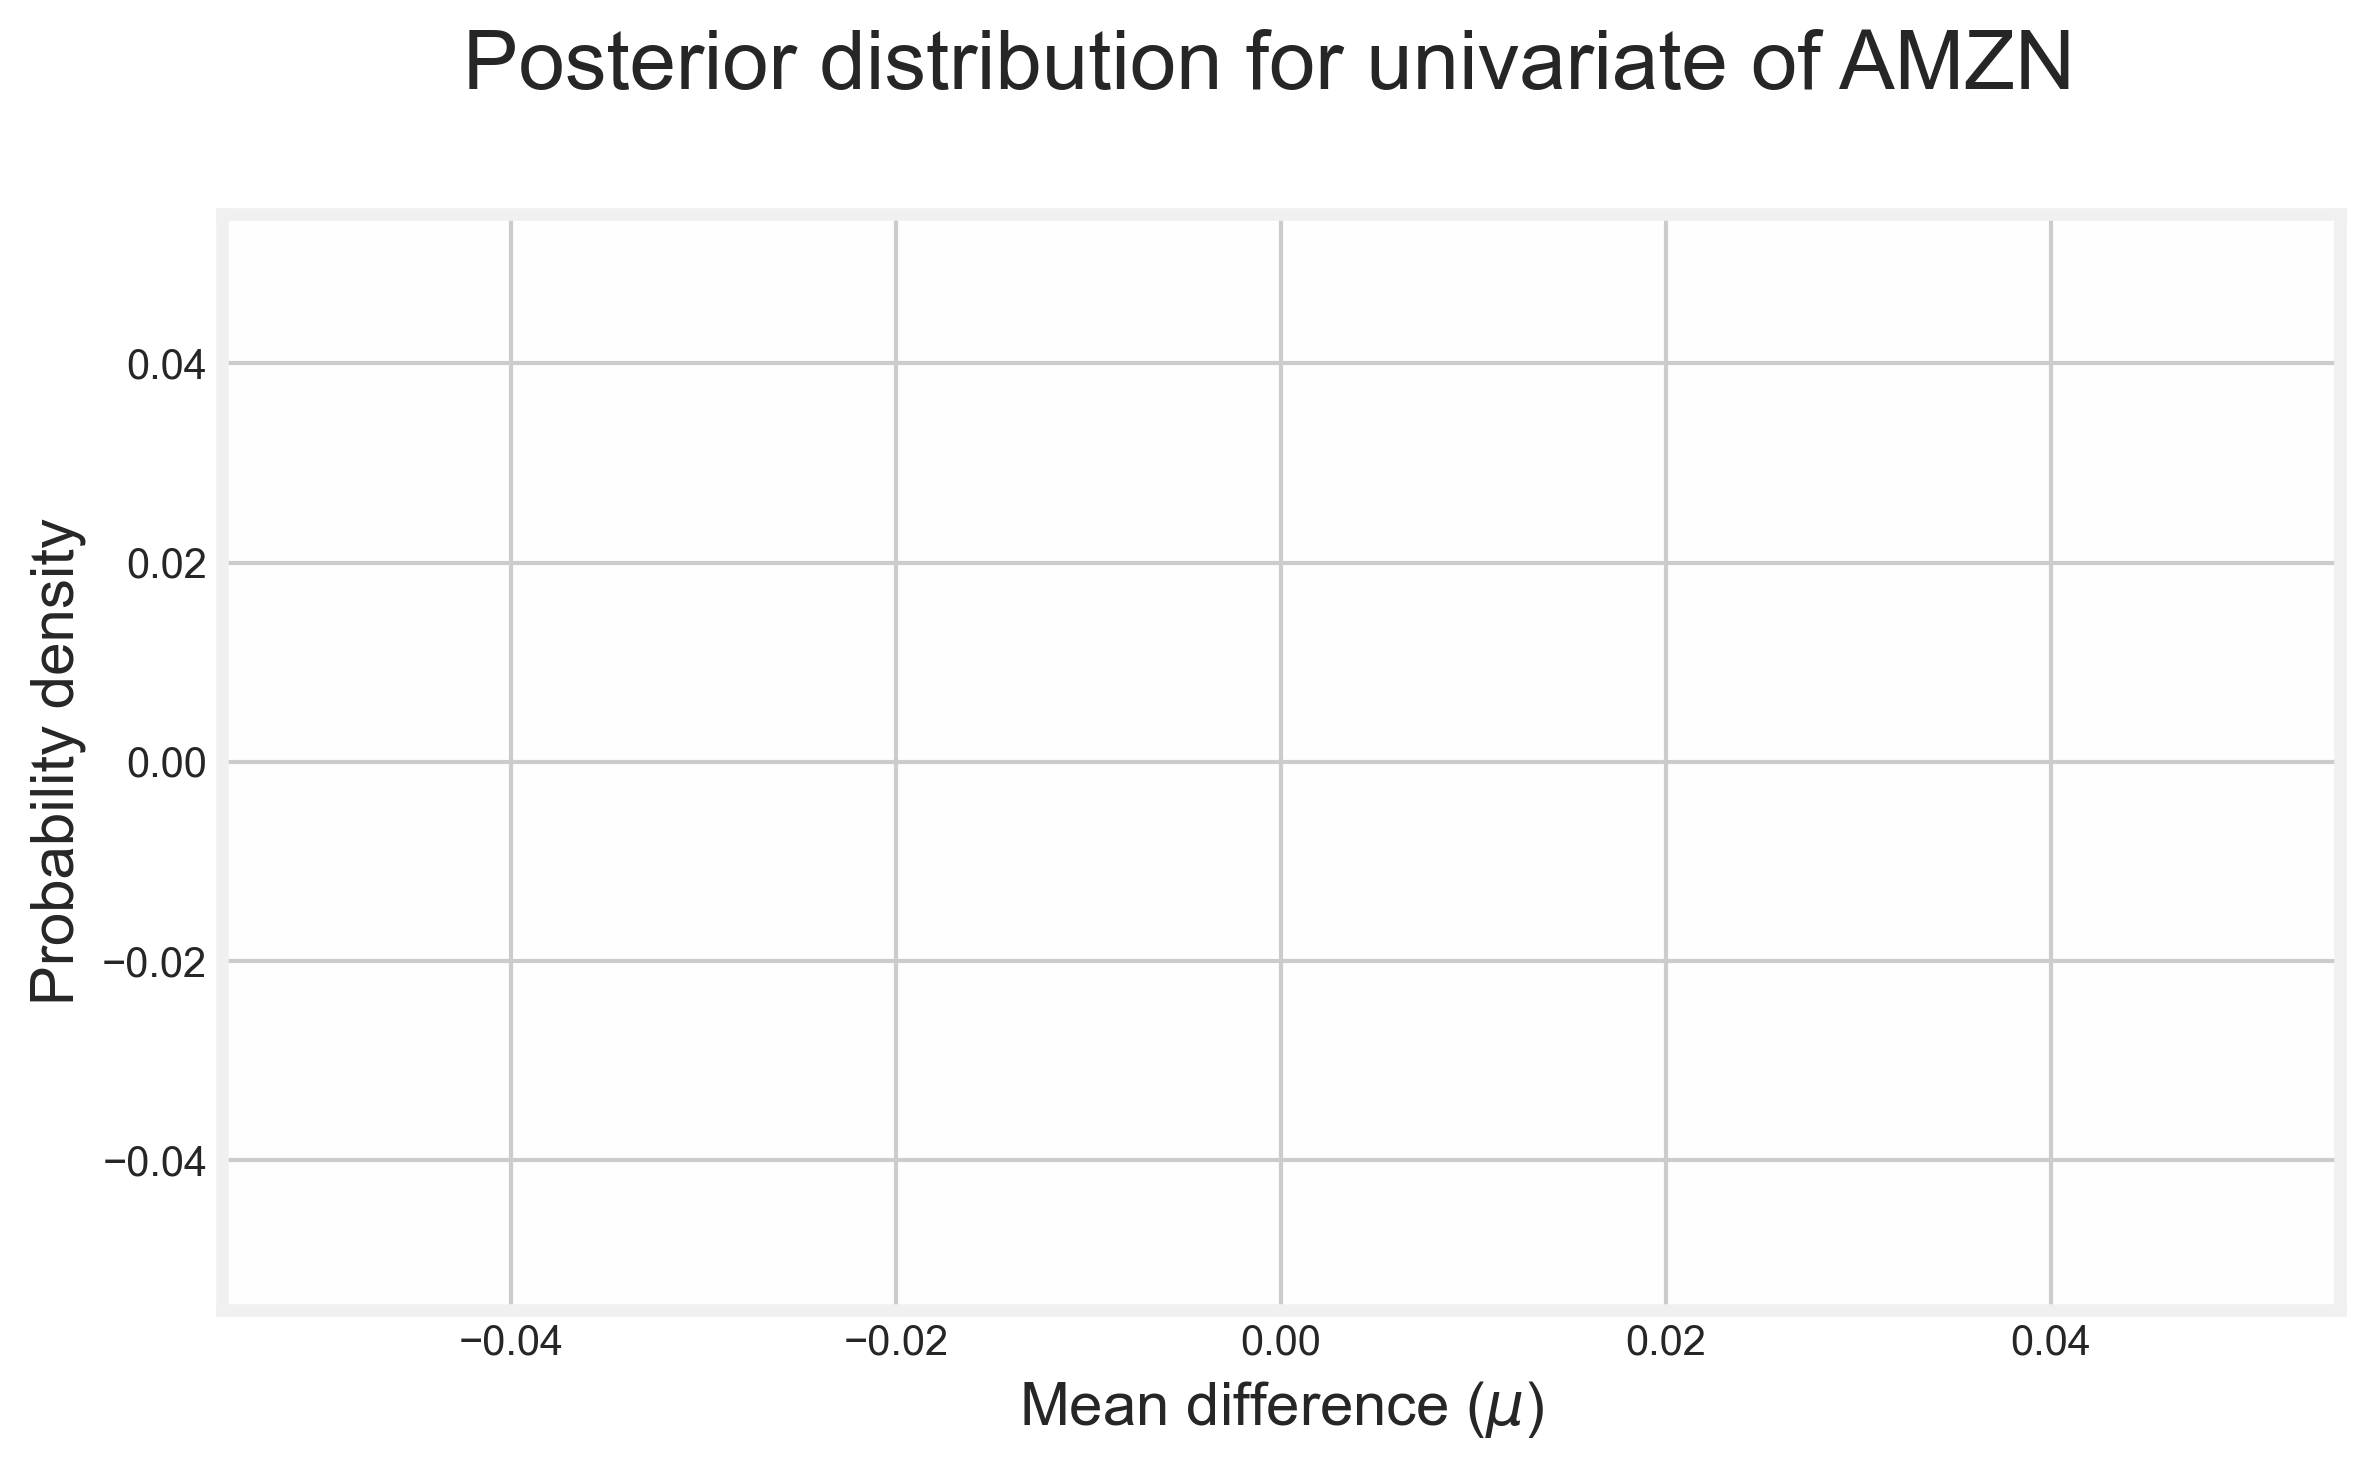

In [46]:
plotting.plot_post_distribution(t_post, ticker, n_steps, n_steps_ahead)

In [47]:
better_prob = 1 - t_post.cdf(0)

print(f"Probability of model {model_scores.index[0]} being more accurate than "
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Probability of model {model_scores.index[1]} being more accurate than "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Probability of model 0 being more accurate than 1: nan
Probability of model 1 being more accurate than 0: nan


Saving figure:  Histogramm_plot_price_AMZN_n_steps_21_n_steps_ahead_1


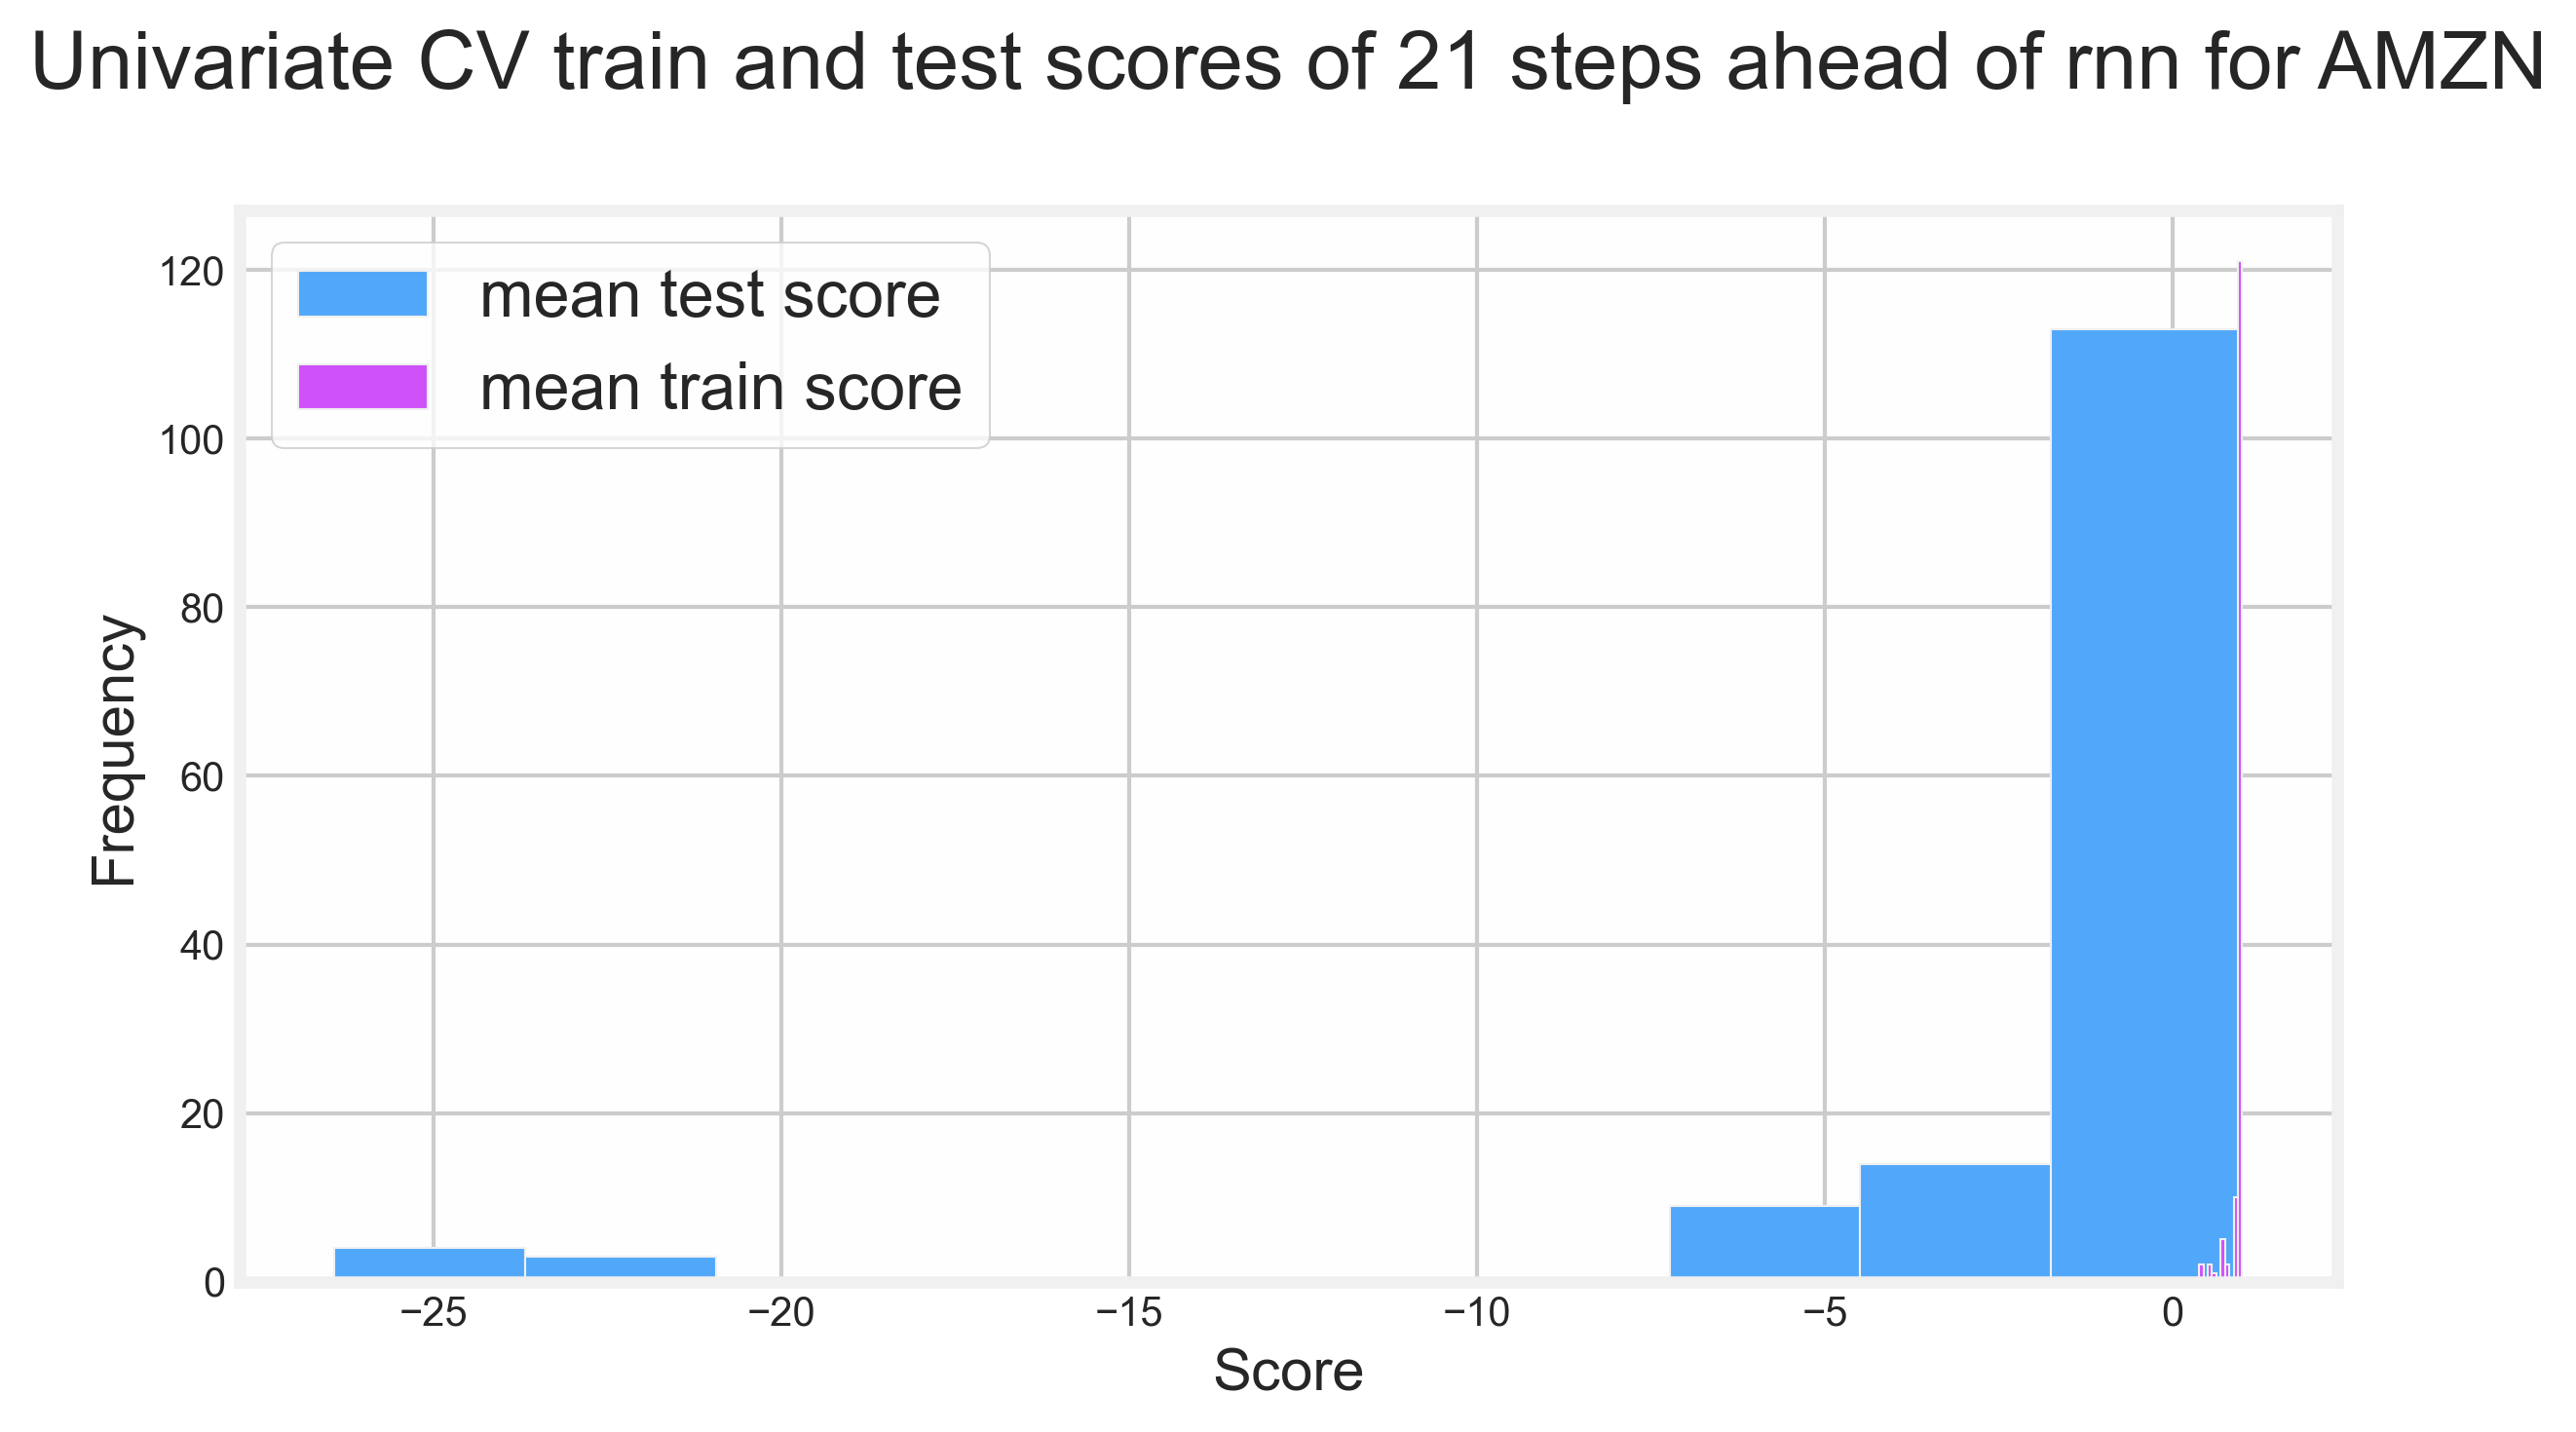

In [48]:
plotting.plot_CV_histogram(results_df, key, ticker, n_steps, n_steps_ahead)

## Rescaled model metrics 

In [49]:
predicted = params[key]['pred_test']

In [50]:
# get rescaled MAPE of 
metrics_df = ma.get_rescaled_mape_r2(y_test, predicted, mu, sigma, n_steps_ahead)
metrics_df

MAPE    $R^2$
lag                 
1    22.172  -0.1196

In [51]:
analysis_path = '../../model_analysis/'
analysis_folder = '{}/'.format(ticker)

analysis_file_name = '_metrics_df-price-{}-{}-n_steps.csv'.format(
    ticker, n_steps)

metrics_df.to_csv(analysis_path + analysis_folder + key + analysis_file_name)

# Plot observed vs. predicted

Saving figure:  rnn_stock_price_plot_price_AMZN_n_steps_21_n_steps_ahead_1


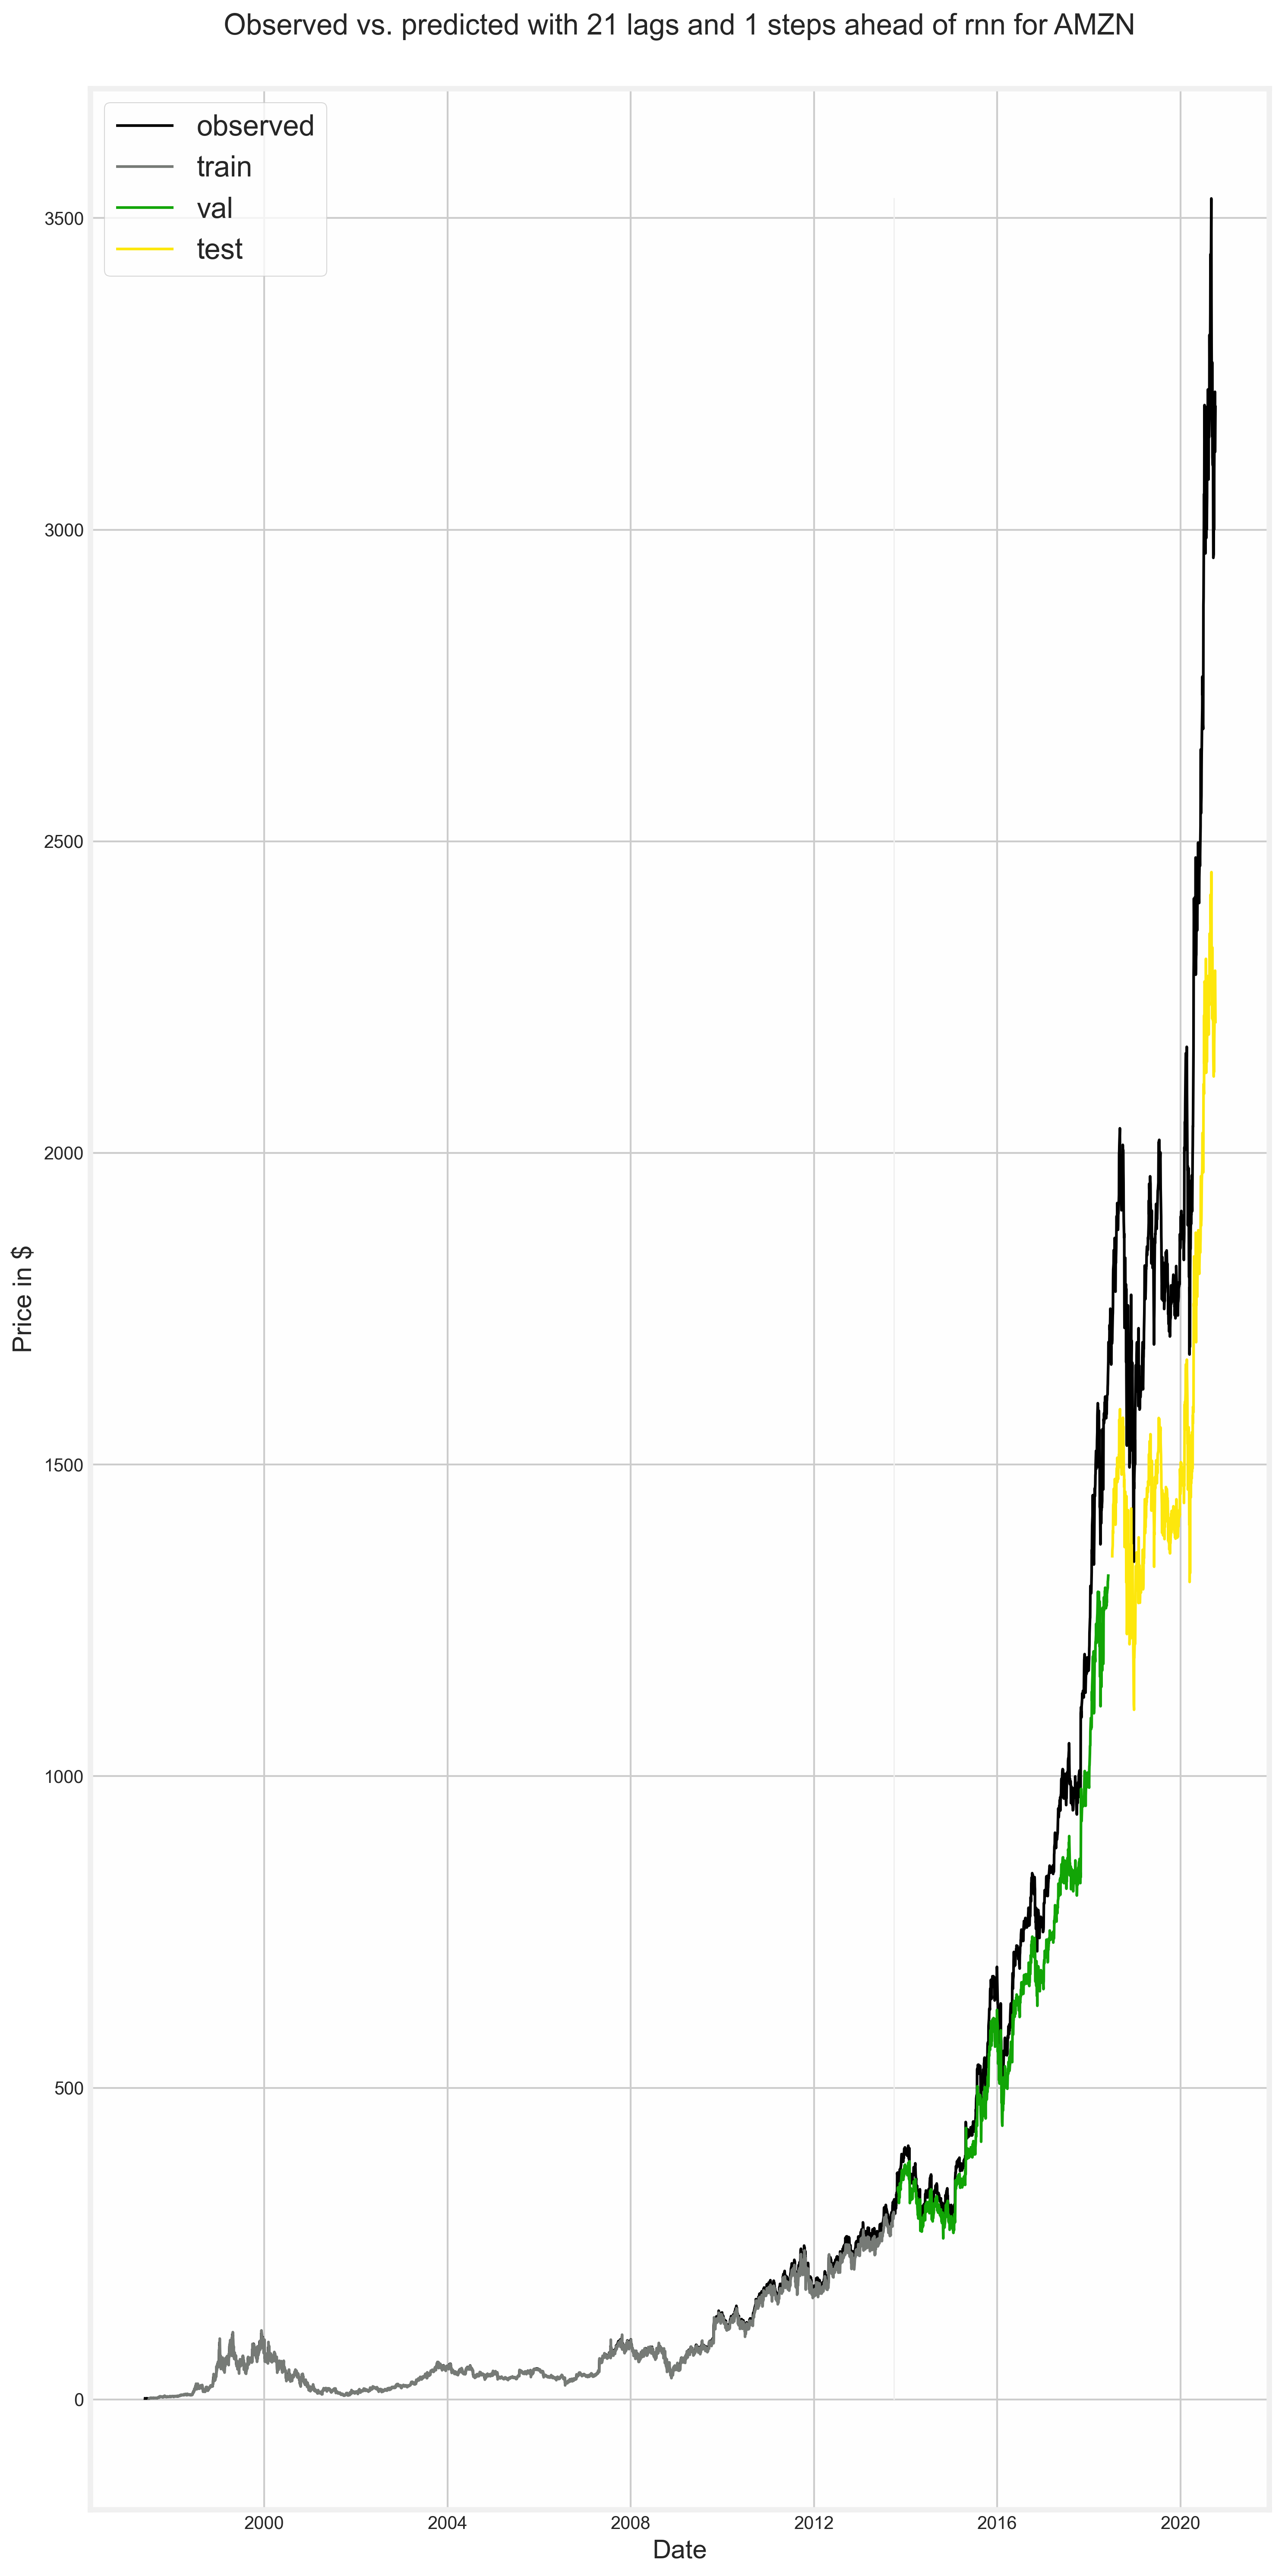

In [52]:
# rescale observed and predicted to compare
plotting.scaled_observed_vs_predicted_plot(data, key, ticker, data_train, data_val,
                                           data_test, mu, sigma, params, n_steps, n_steps_ahead)

# Error bootstrapping

In [53]:
bts = BootstrappingWrapper(
    data_test, bootstrap_type='mbb', block_length=n_steps+n_steps_ahead)
bts_samples = bts.sample(data_test, n_samples=1000)
bts_samples.shape

(1000, 589, 1)

In [54]:
# split the bootstrapped time series into lagged features for the network
metrics_dict = {'mape': []}
for i in tqdm(range(bts_samples.shape[0])):
    bts_samples_df = pd.DataFrame(bts_samples[i])
    x_test = ma.get_lagged_features_bootstrapping(
        bts_samples_df, n_steps, n_steps_ahead)[::n_steps+n_steps_ahead]
    y_test = ma.get_lagged_features_bootstrapping(bts_samples_df, n_steps_ahead, n_steps_ahead)[
        n_steps::n_steps+n_steps_ahead, :, 0]

    # make predictions
    y_pred = model.predict(x_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    metrics_dict['mape'].append(mape)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


Saving figure:  AMZN_eror distribution_plot_21_n_steps_of_rnn_uni


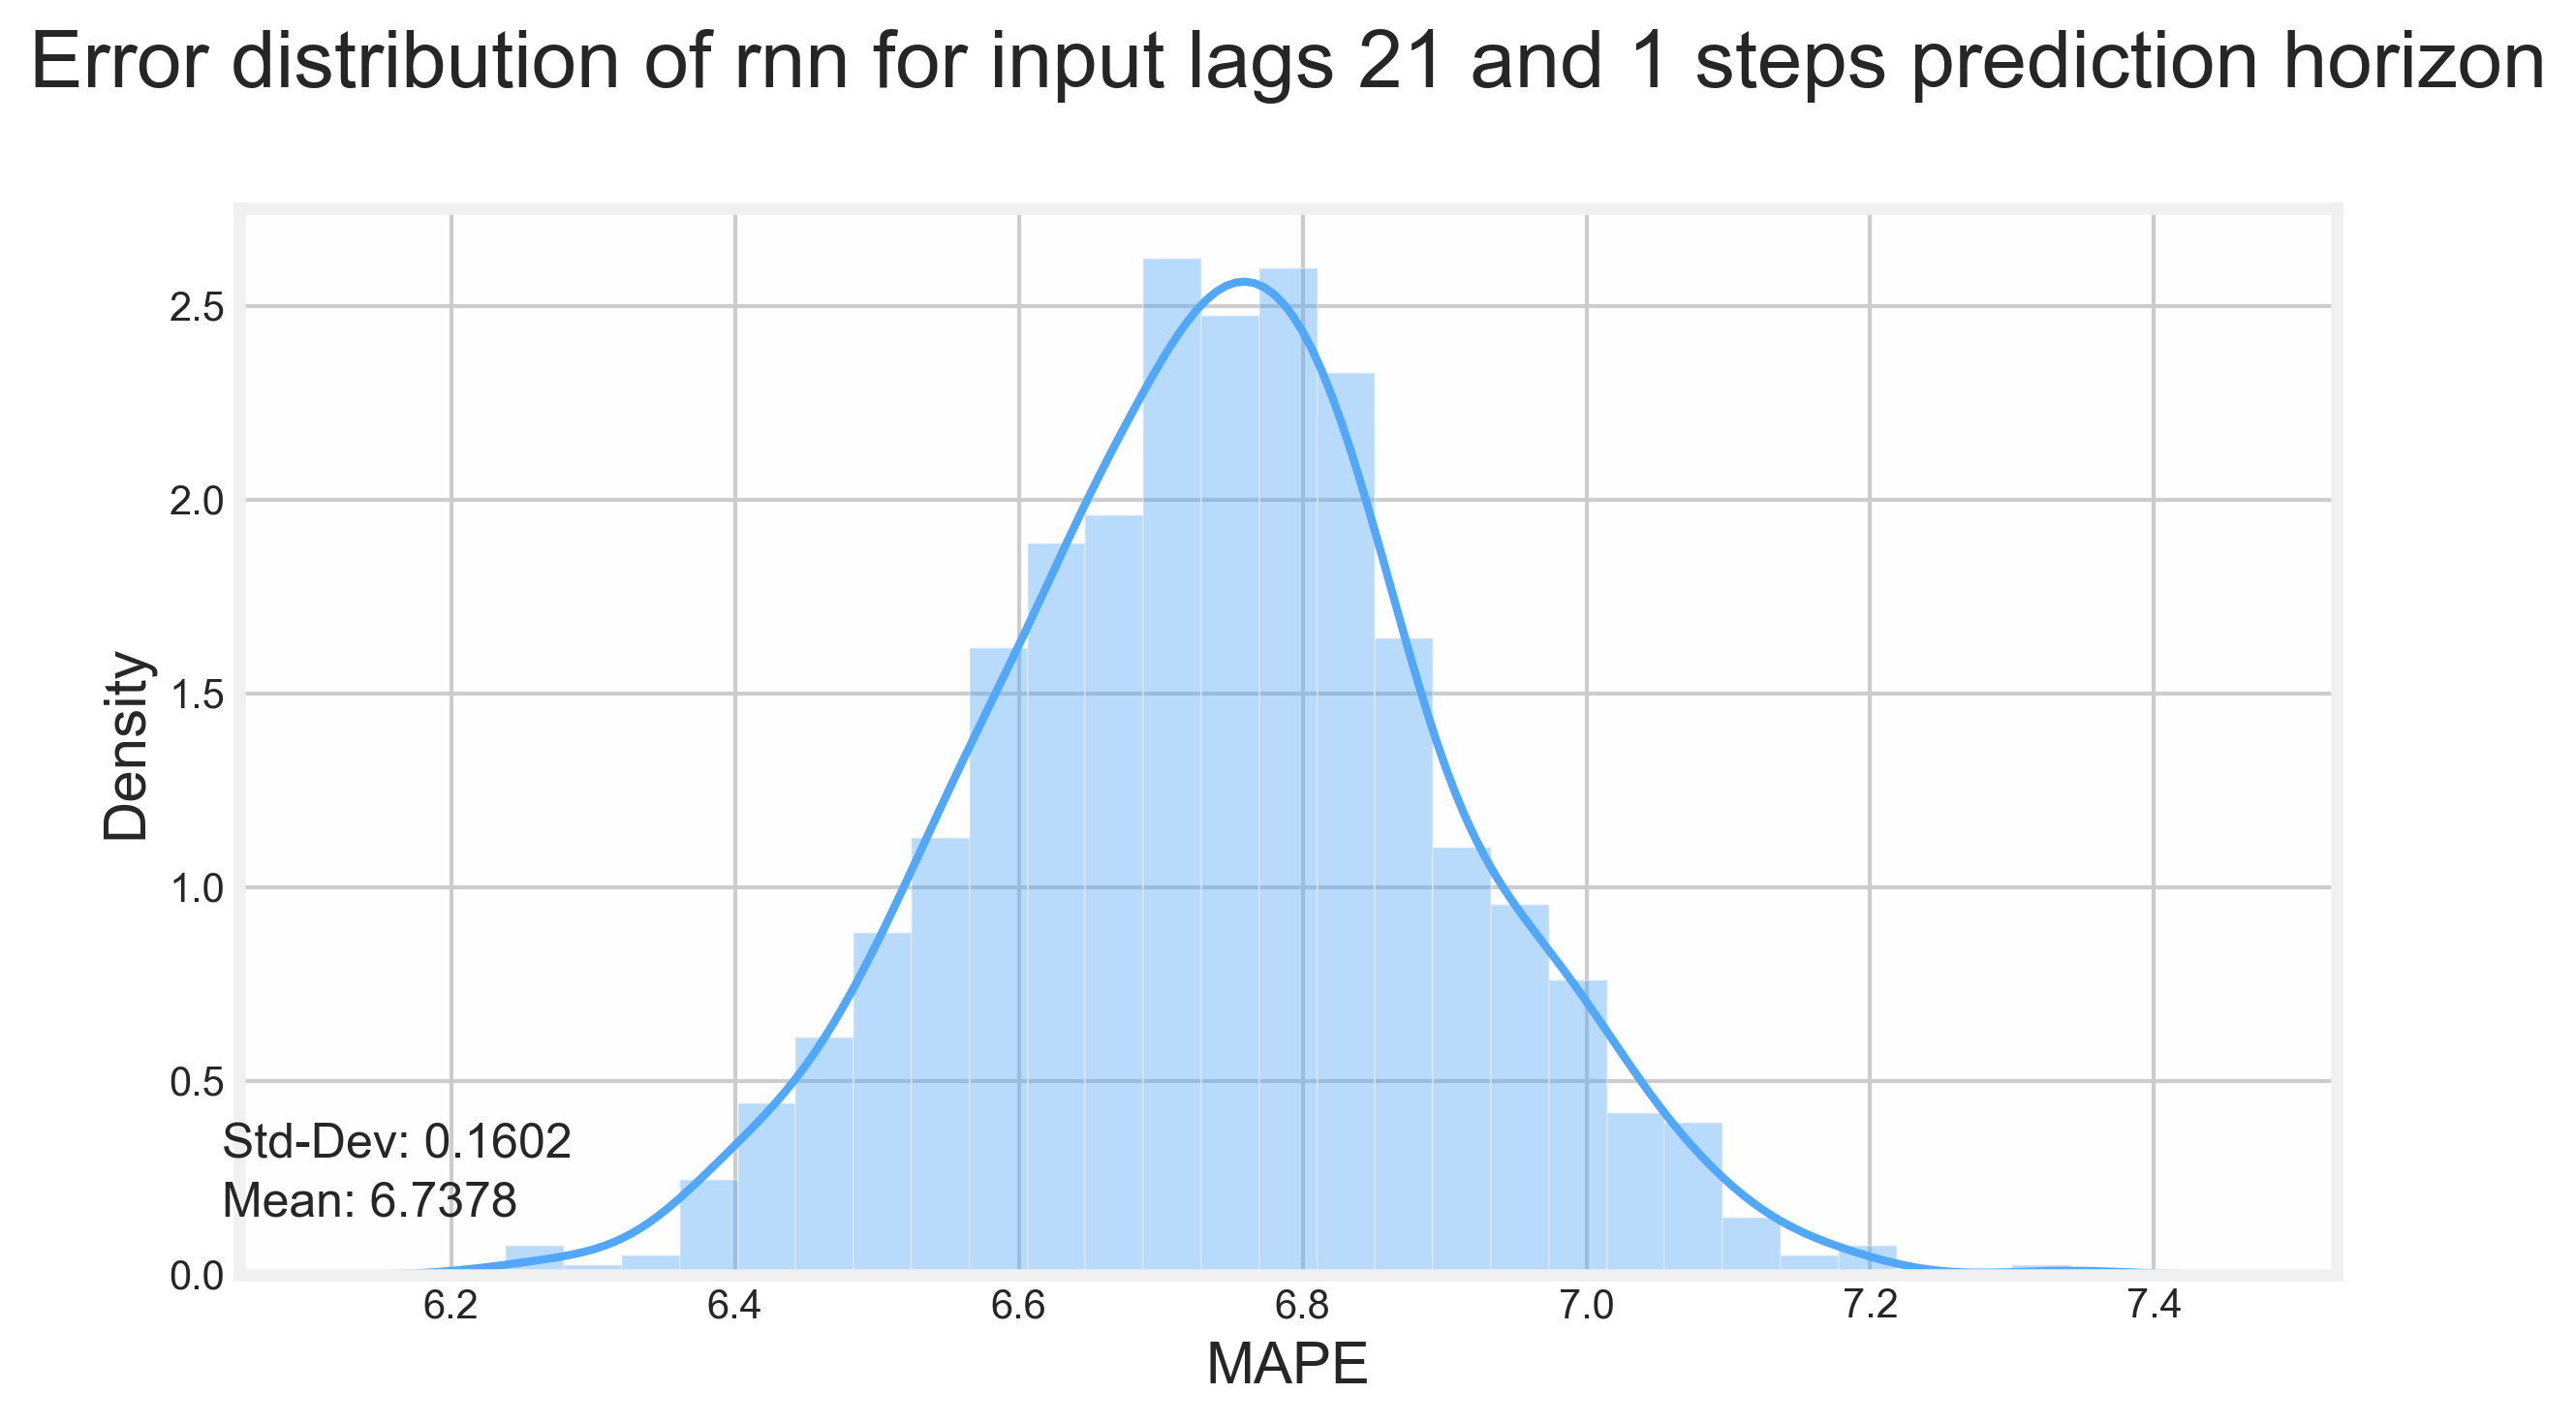

In [55]:
title = 'Error distribution of {} for input lags {} and {} steps prediction horizon'.format(
    key, n_steps, n_steps_ahead)

fig_name = '{}_eror distribution_plot_{}_n_steps_of_{}_uni'.format(ticker, n_steps, key)


plotting.error_distribution_plot(metrics_dict['mape'], title, fig_name)

In [56]:
ma.print_error_confidence_interval(metrics_dict['mape'], n_steps_ahead, ticker, key, n_steps)

 95% Confidence interval for rnn for 21 input
 lags and 1 steps prediction horizon for AMZN stock
50th percentile (median): 			6.741
2.5th percentile: 				6.4145
97.5th percentile: 				7.0592


# Tensorboard

In [57]:
str_path = '../../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key

path = Path(str_path)

In [58]:
path

PosixPath('../../logs/fit/AMZN_21_uni_rnn')

In [62]:
%load_ext tensorboard

# uncomment the function below to gain more insight of the models behavior
#%tensorboard --logdir ../../logs/fit/AMZN_21_uni_rnn

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


[Link on how to log your models](https://www.tensorflow.org/tensorboard/scalars_and_keras)